# Imports

In [21]:
import warnings
import pandas  as pd

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

In [22]:
warnings.filterwarnings("ignore")

In [23]:
from dstoolkit.feature_engine import SimpleLagTimeFeatureCreator

In [24]:
from dstoolkit.automl import AutoMLLGBMRegressor, AutoMLLGBMRegressorCV

# Regressor

In [25]:
df = pd.read_csv('../data/global_temperature_time_series.csv', )
df['time'] = pd.to_datetime(df['Year'])
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

s = SimpleLagTimeFeatureCreator([2, 3, 4, 5, 6], ["mean", "median", "max", "min", "std", "diff", "slope"])
df1 = s.create(df, target='temperature', time='time')
df1 = df1.dropna()

X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

In [27]:
rfe = SequentialFeatureSelector(
    LGBMRegressor(verbose=0), 
    n_features_to_select=20, 
    direction='backward',
    scoring='neg_root_mean_squared_error', 
    cv=3
)
rfe.fit(X_train, y_train['temperature'])

best_features_reg = X_train.loc[:, rfe.get_support()].columns.tolist()

In [37]:
a = AutoMLLGBMRegressor(
    X_train, y_train, 
    X_valid, y_valid,
    X_test, y_test,
    target='temperature',
    best_features=best_features_reg,
    n_trials=50,
    scoring='root_mean_squared_error'
)

In [38]:
a.train()

In [39]:
a.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.987406  0.034668  0.027240  5.643267e+11  0.045194   
1   Valid  0.911242  0.090557  0.071248  3.525480e+12  0.119737   
2    Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   
3   Train  0.982190  0.041209  0.033249  4.788525e+11  0.053744   
4   Valid  0.909586  0.092335  0.073149  3.618800e+12  0.120849   
5    Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   
6   Train  0.940192  0.075559  0.059814  8.566546e+11  0.098488   
7   Valid  0.918396  0.088014  0.069708  3.225899e+12  0.114810   
8    Test  0.921753  0.090958  0.072746  1.269381e+00  0.117472   

   Explained Variance               Model  
0            0.987406          Base Model  
1            0.911242          Base Model  
2            0.911752          Base Model  
3            0.982190  Best Feature Model  
4            0.909586  Best Feature Model  
5            0.916690  Best Feature Model  
6            0.940192   Best Params Model  
7            0.918400   Best Params Model  
8            0.921988   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.987406  0.034668  0.027240  5.643267e+11  0.045194   
1   Valid  0.911242  0.090557  0.071248  3.525480e+12  0.119737   
2    Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   

   Explained Variance  
0            0.987406  
1            0.911242  
2            0.911752

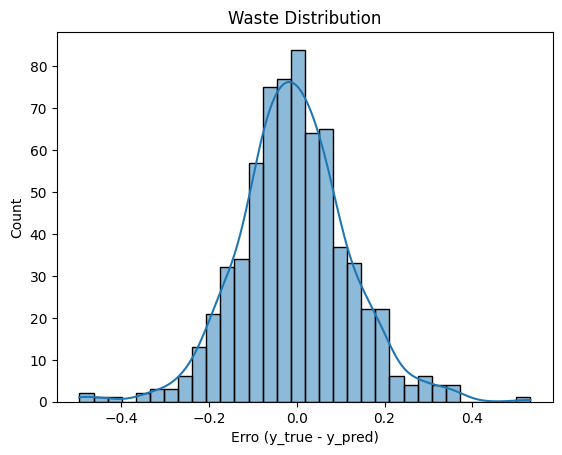

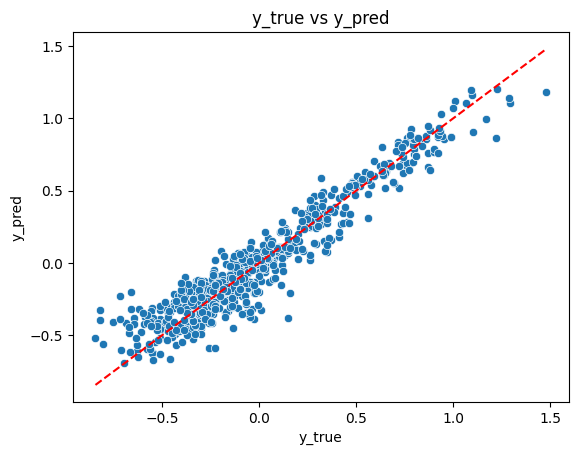

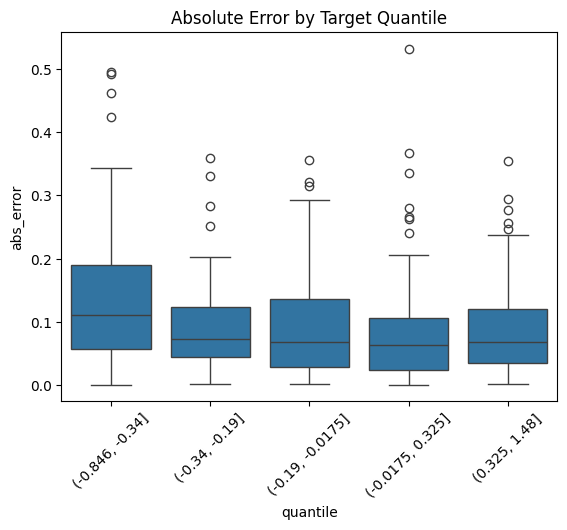

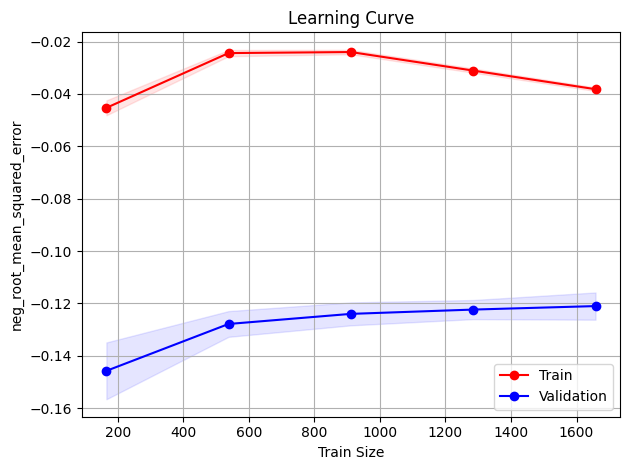

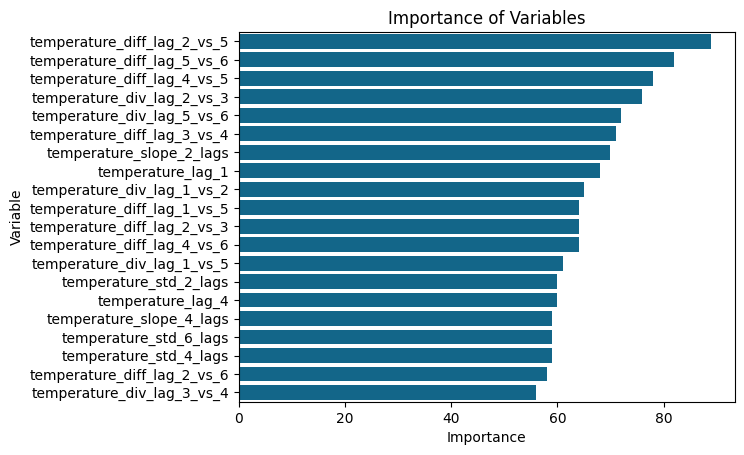

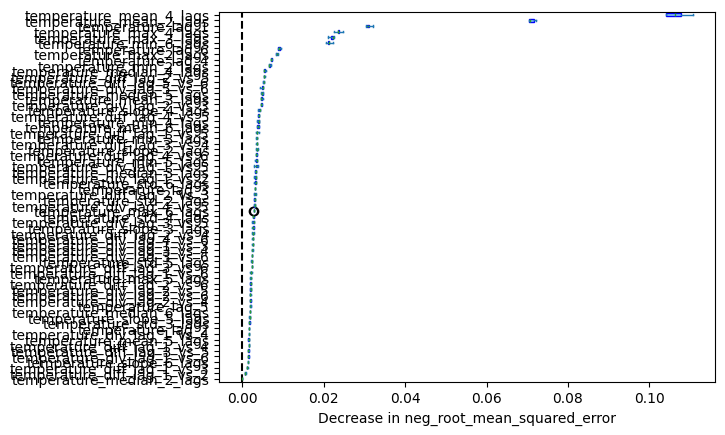

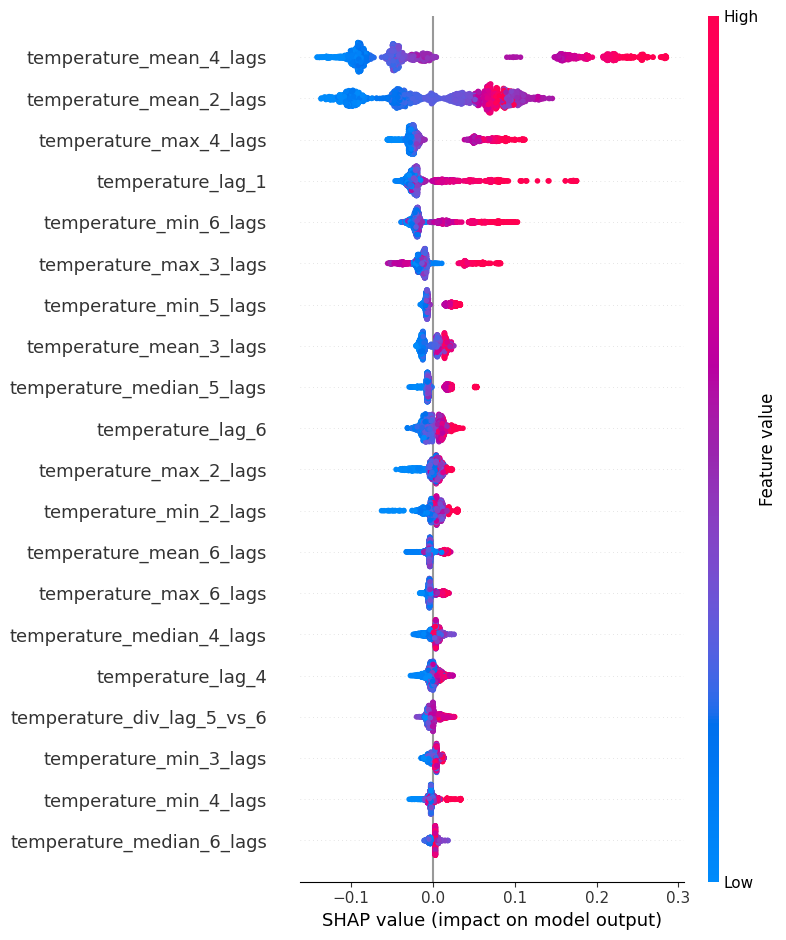

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.982190  0.041209  0.033249  4.788525e+11  0.053744   
1   Valid  0.909586  0.092335  0.073149  3.618800e+12  0.120849   
2    Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   

   Explained Variance  
0            0.982190  
1            0.909586  
2            0.916690

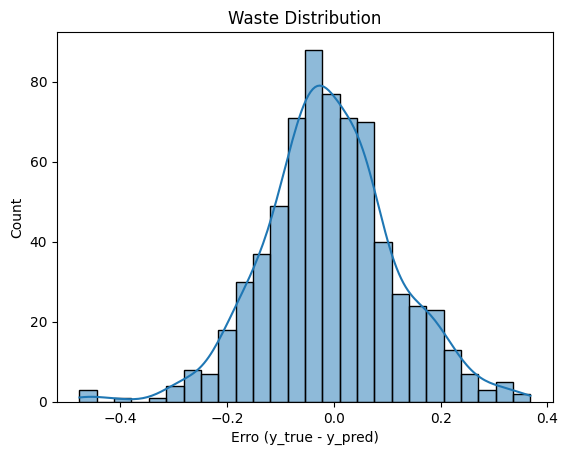

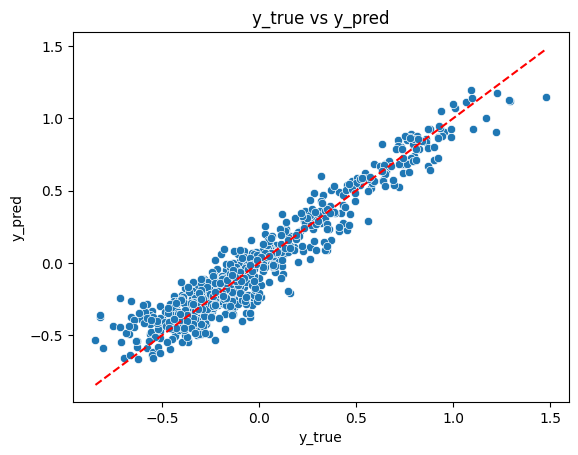

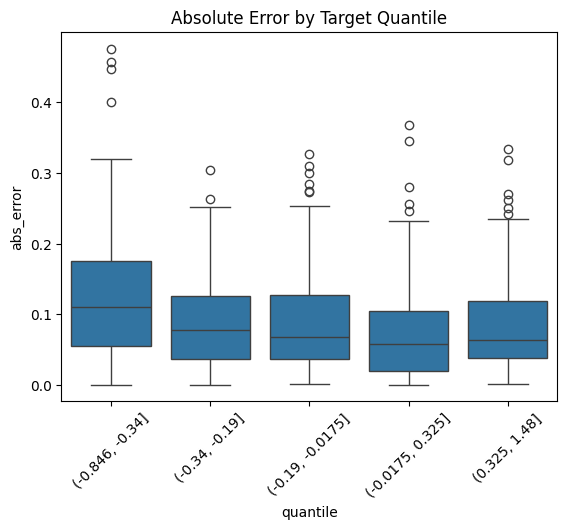

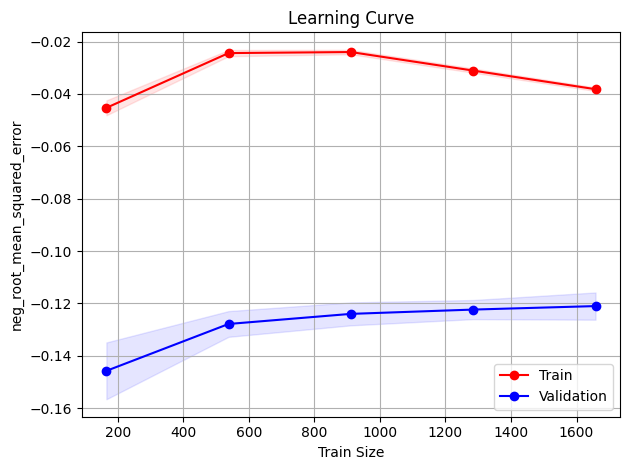

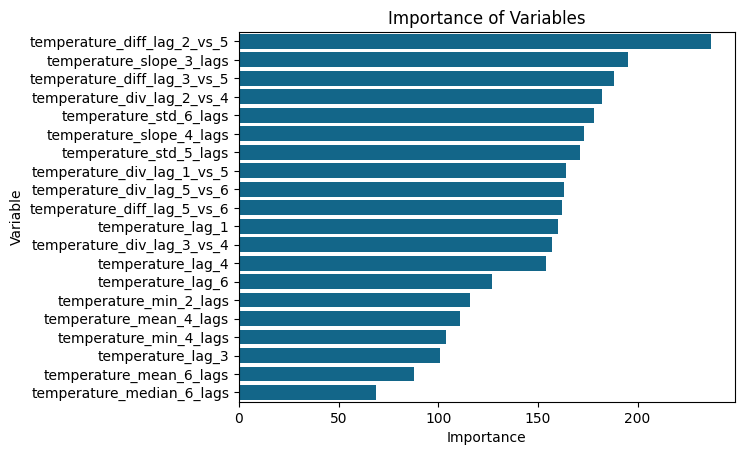

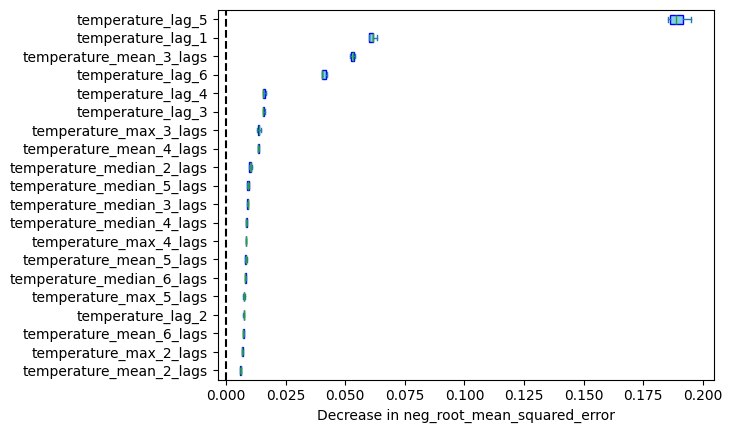

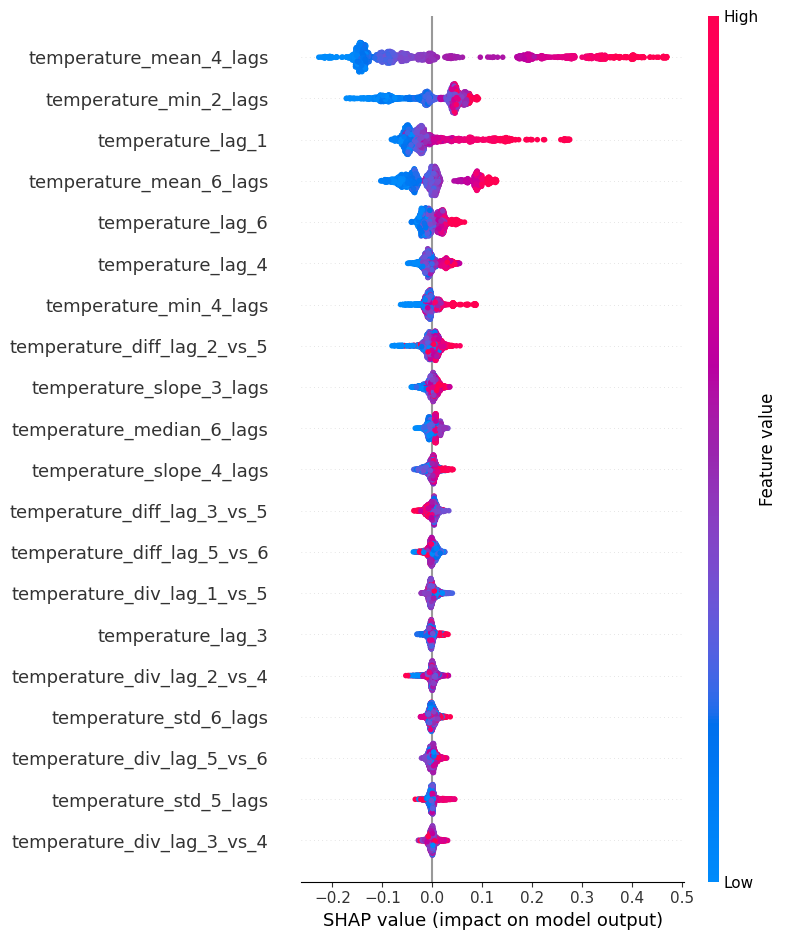

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.940192  0.075559  0.059814  8.566546e+11  0.098488   
1   Valid  0.918396  0.088014  0.069708  3.225899e+12  0.114810   
2    Test  0.921753  0.090958  0.072746  1.269381e+00  0.117472   

   Explained Variance  
0            0.940192  
1            0.918400  
2            0.921988

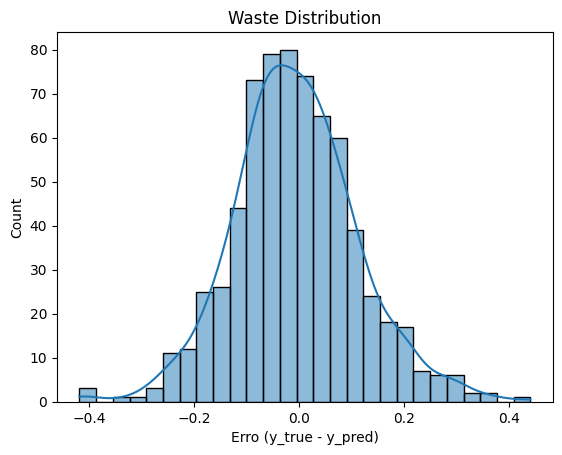

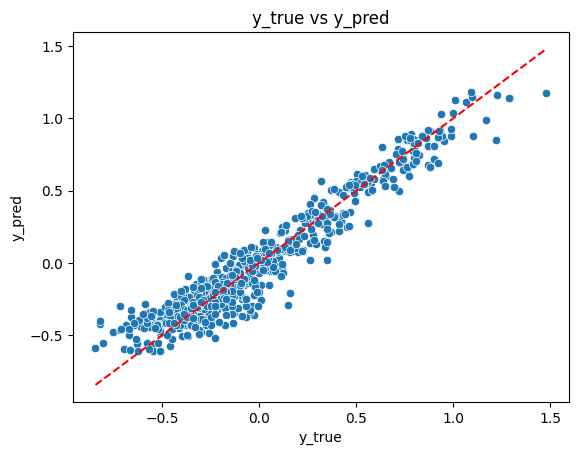

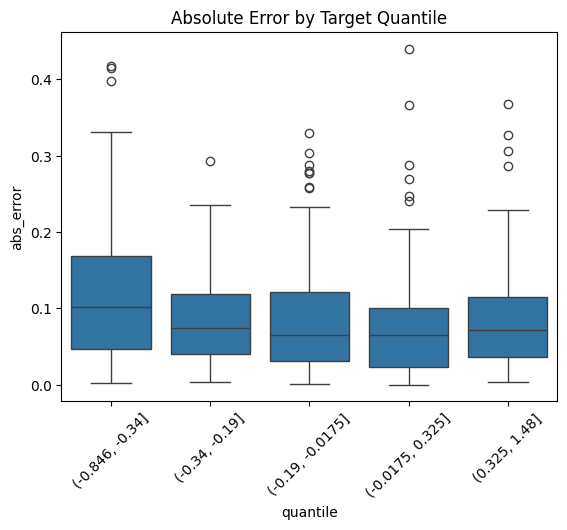

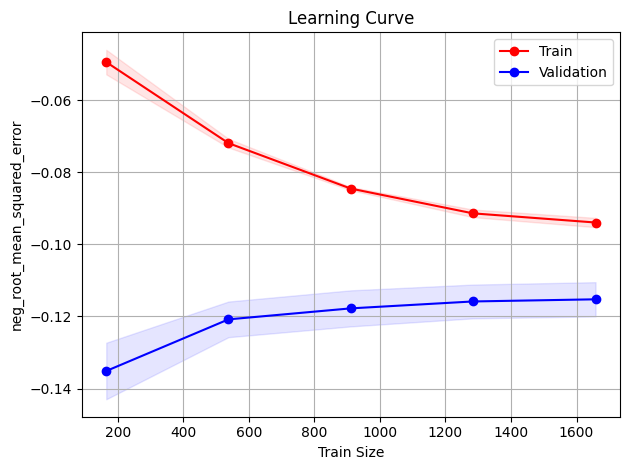

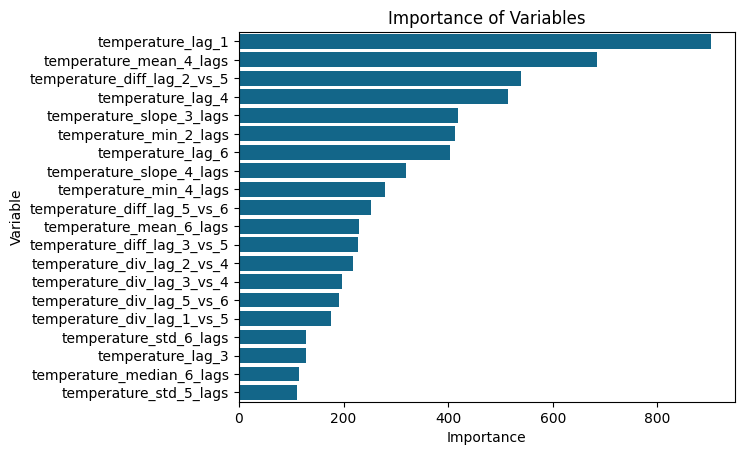

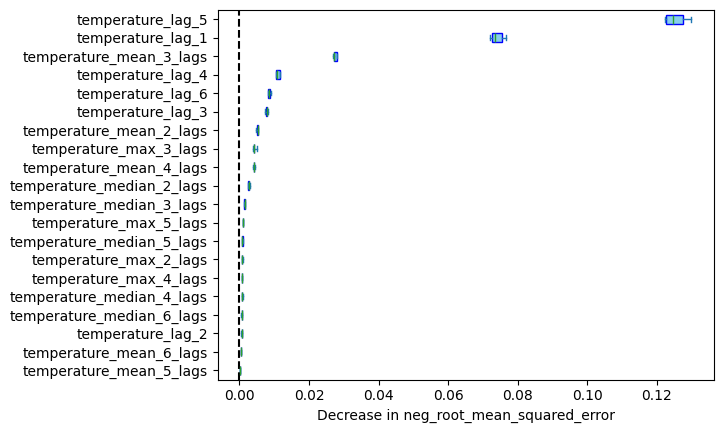

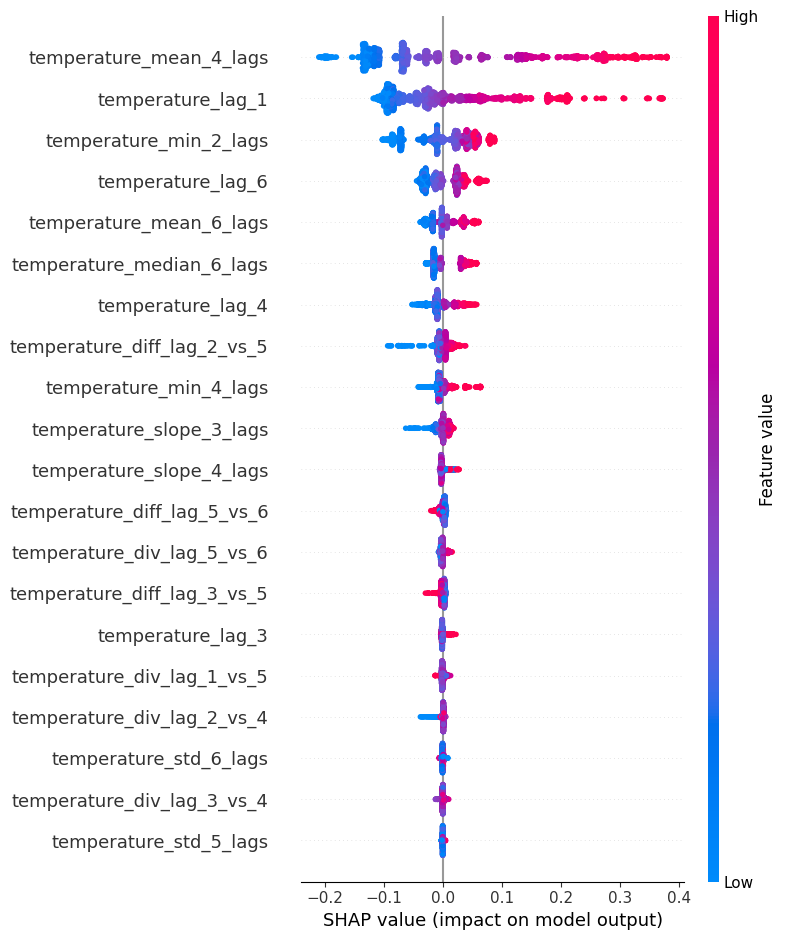

In [40]:
a.get_result_analysis()

In [32]:
acv = AutoMLLGBMRegressorCV(
    X_train, y_train, 
    X_test, y_test,
    target='temperature',
    cv=KFold(shuffle=True, random_state=42),
    best_features=best_features_reg,
    n_trials=50,
    scoring='mean_absolute_error',
    random_state=42
)

In [33]:
acv.train()

In [34]:
acv.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.908385  0.091670  0.072982  1.234447e+12  0.121017   
1      Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   
2  Train CV  0.912559  0.090638  0.071713  9.396324e+11  0.118250   
3      Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   
4  Train CV  0.915560  0.089005  0.071618  1.163013e+12  0.116308   
5      Test  0.918544  0.091964  0.071160  1.276041e+00  0.119857   

   Explained Variance               Model  
0            0.909765          Base Model  
1            0.911752          Base Model  
2            0.913835  Best Feature Model  
3            0.916690  Best Feature Model  
4            0.916761   Best Params Model  
5            0.918777   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.908385  0.091670  0.072982  1.234447e+12  0.121017   
1      Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   

   Explained Variance  
0            0.909765  
1            0.911752

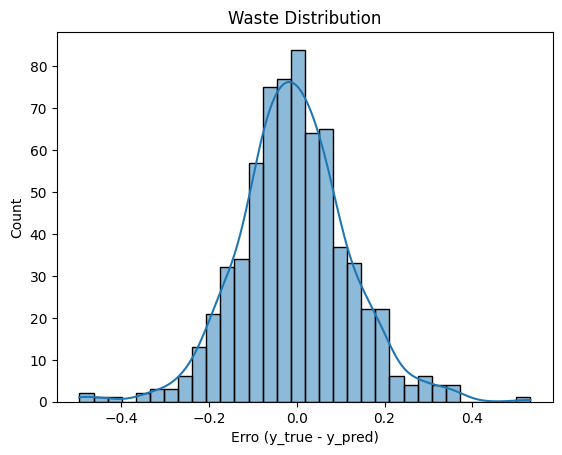

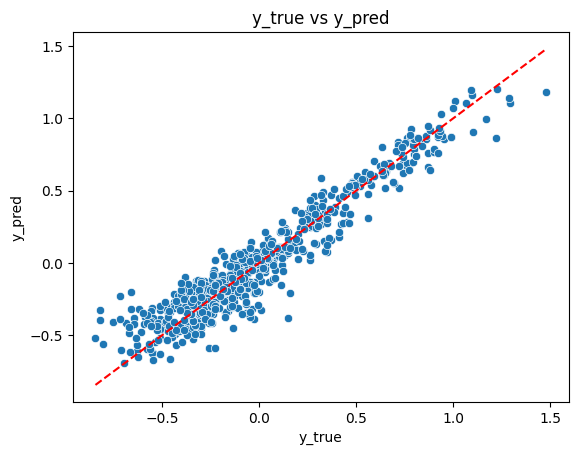

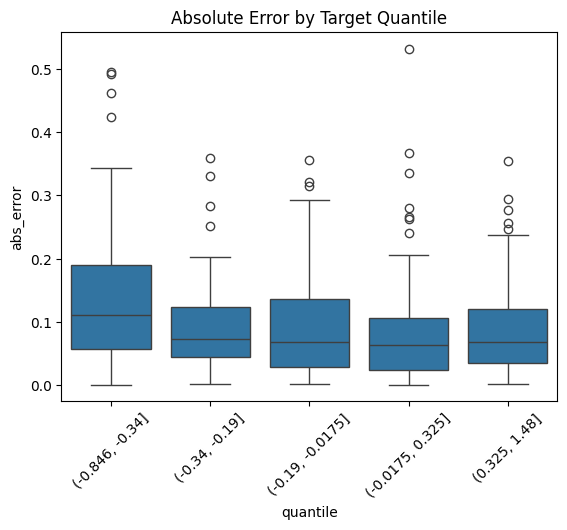

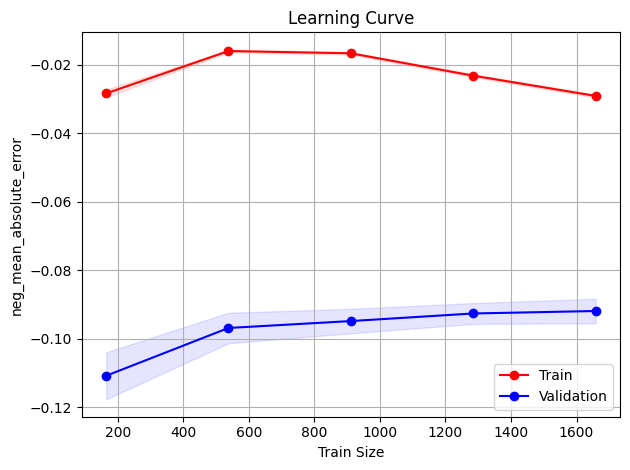

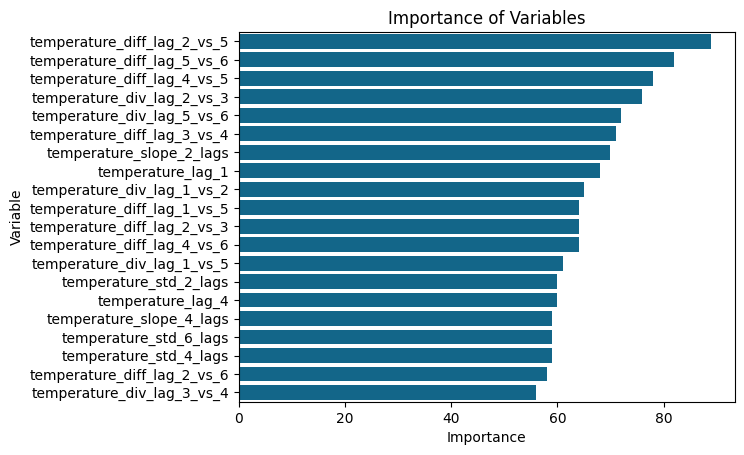

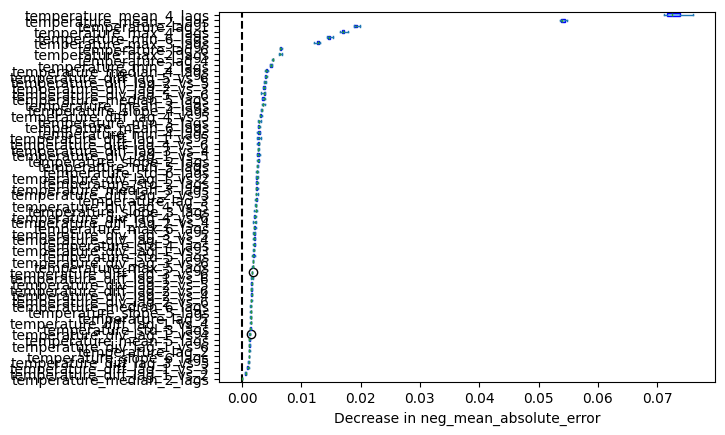

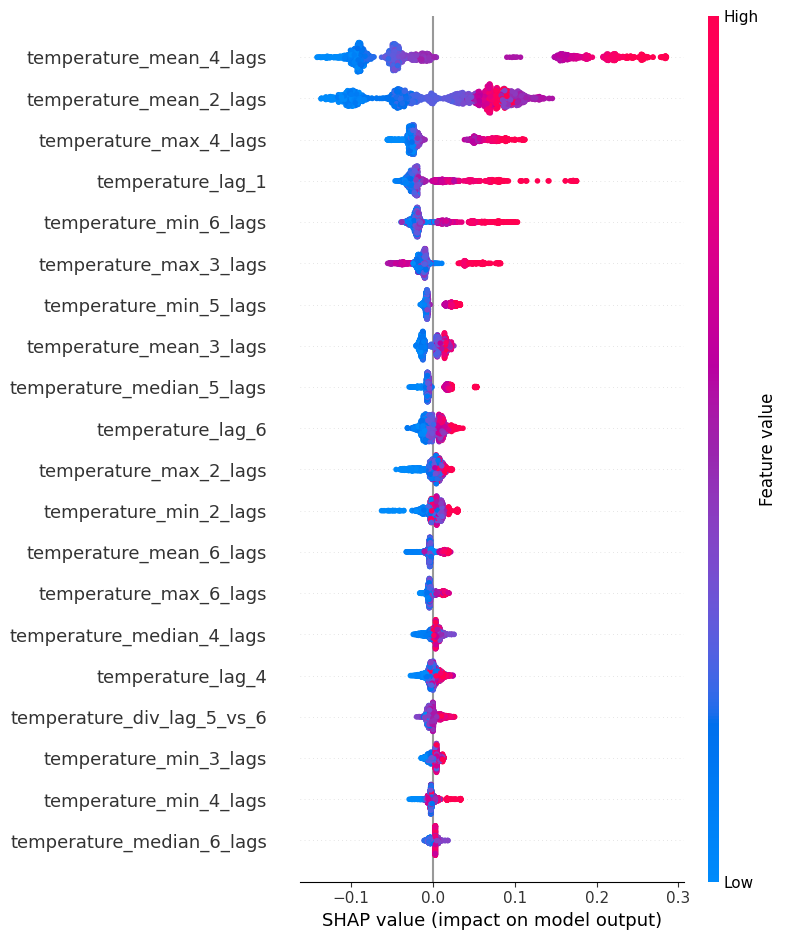

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.912559  0.090638  0.071713  9.396324e+11  0.118250   
1      Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   

   Explained Variance  
0            0.913835  
1            0.916690

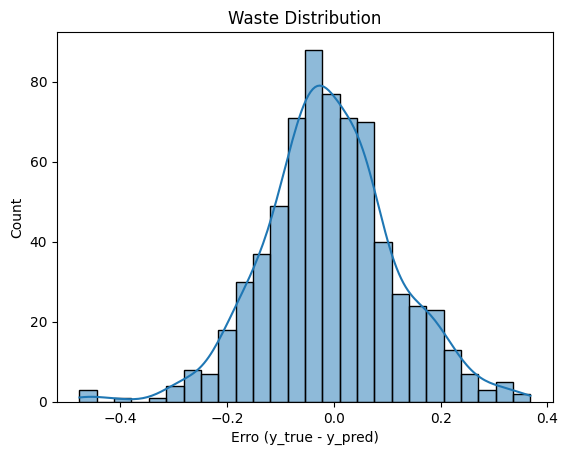

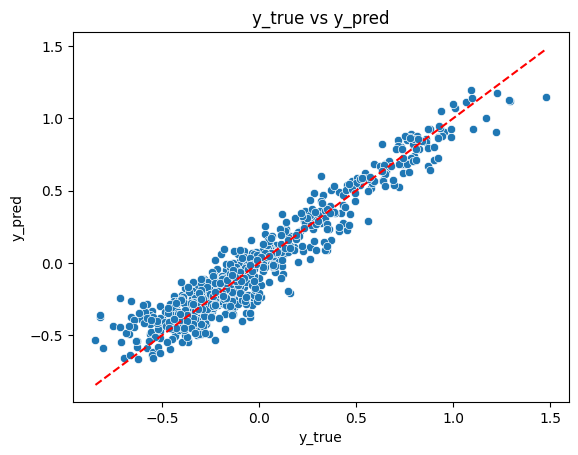

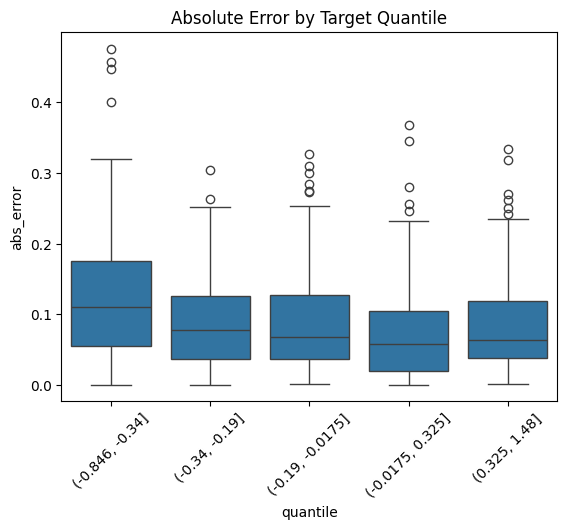

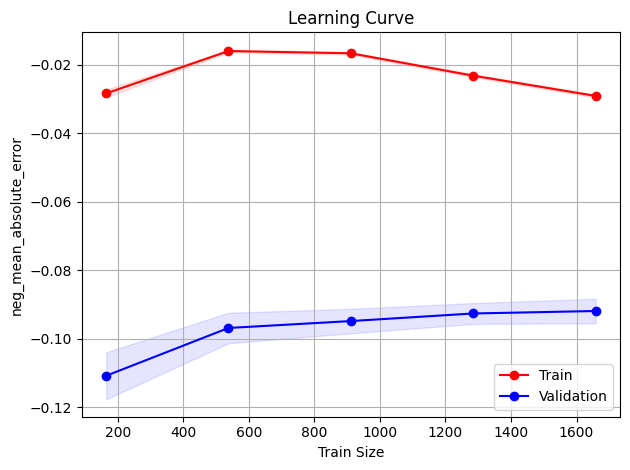

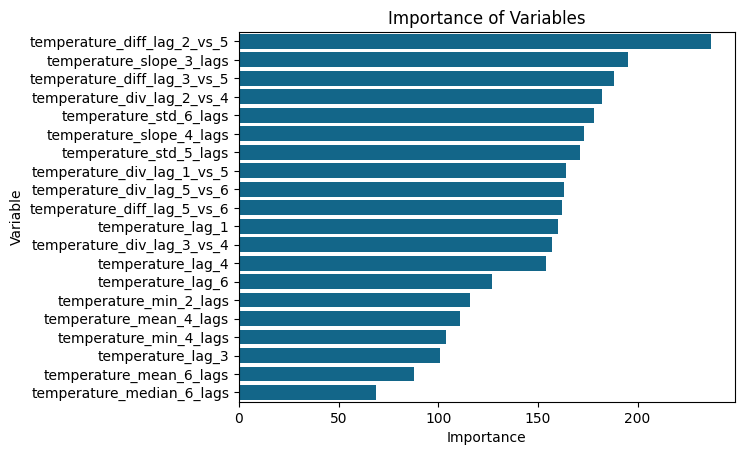

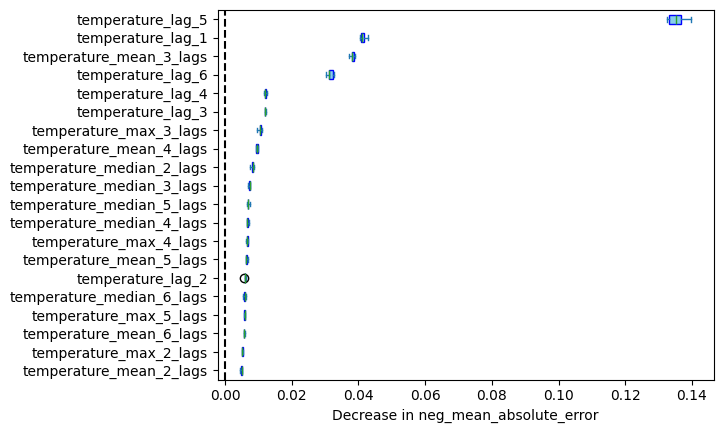

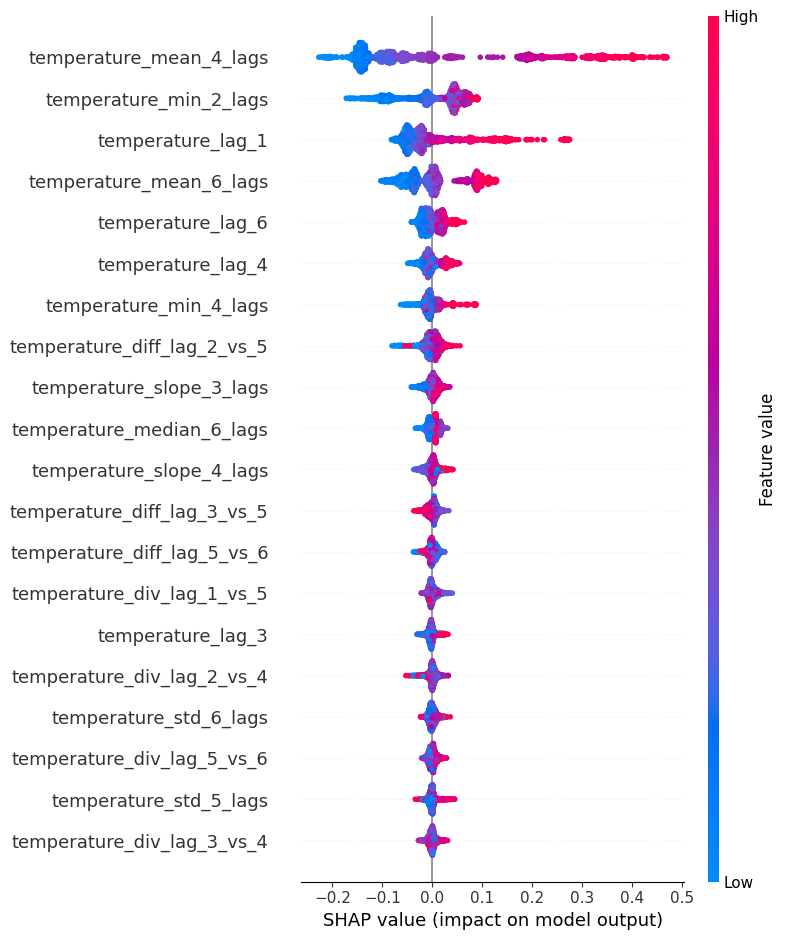

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.915560  0.089005  0.071618  1.163013e+12  0.116308   
1      Test  0.918544  0.091964  0.071160  1.276041e+00  0.119857   

   Explained Variance  
0            0.916761  
1            0.918777

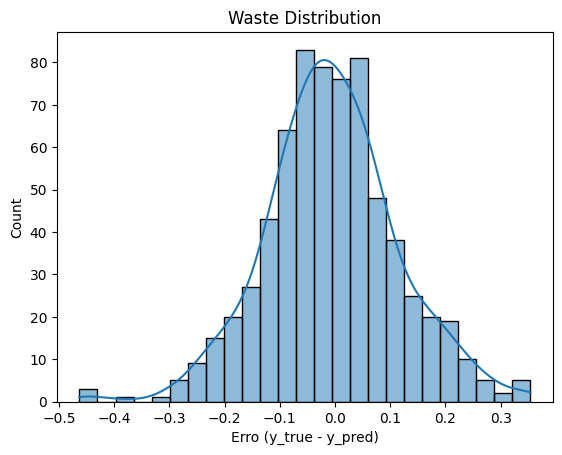

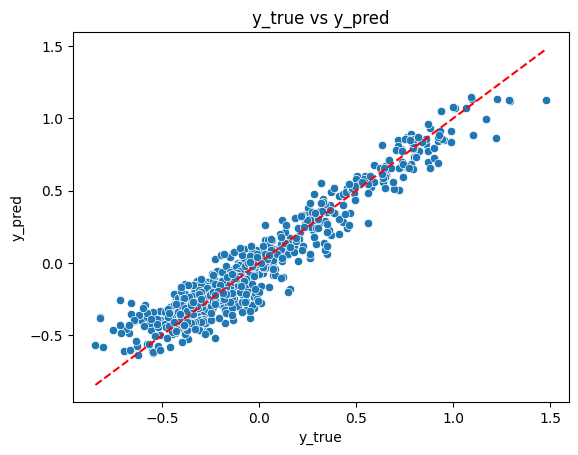

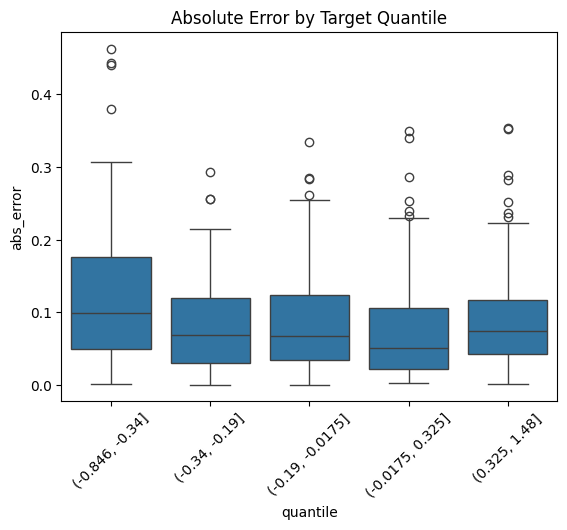

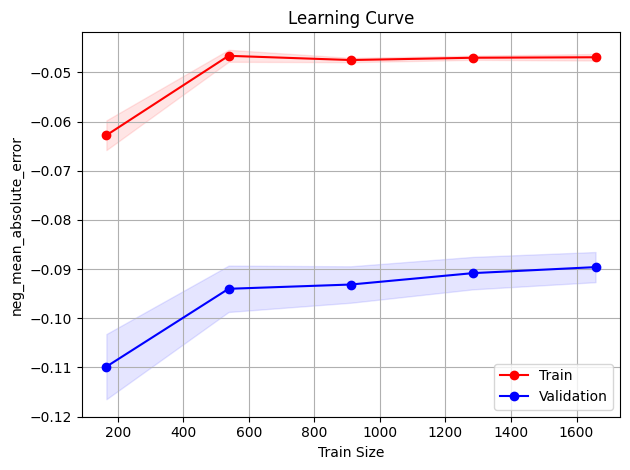

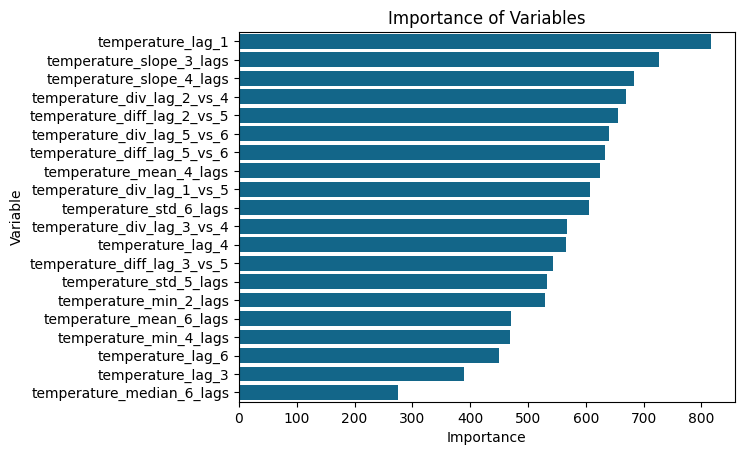

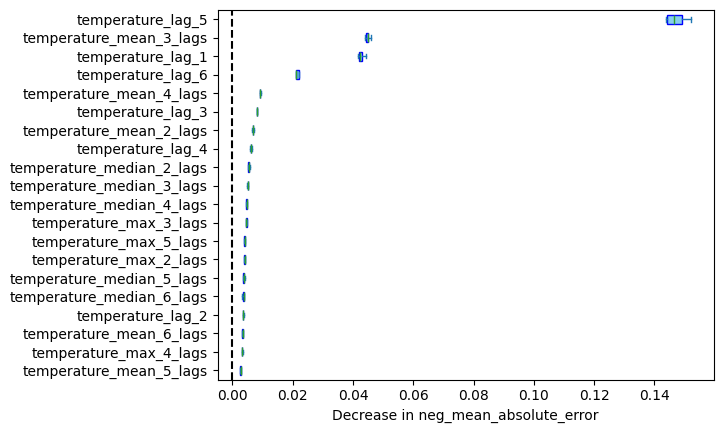

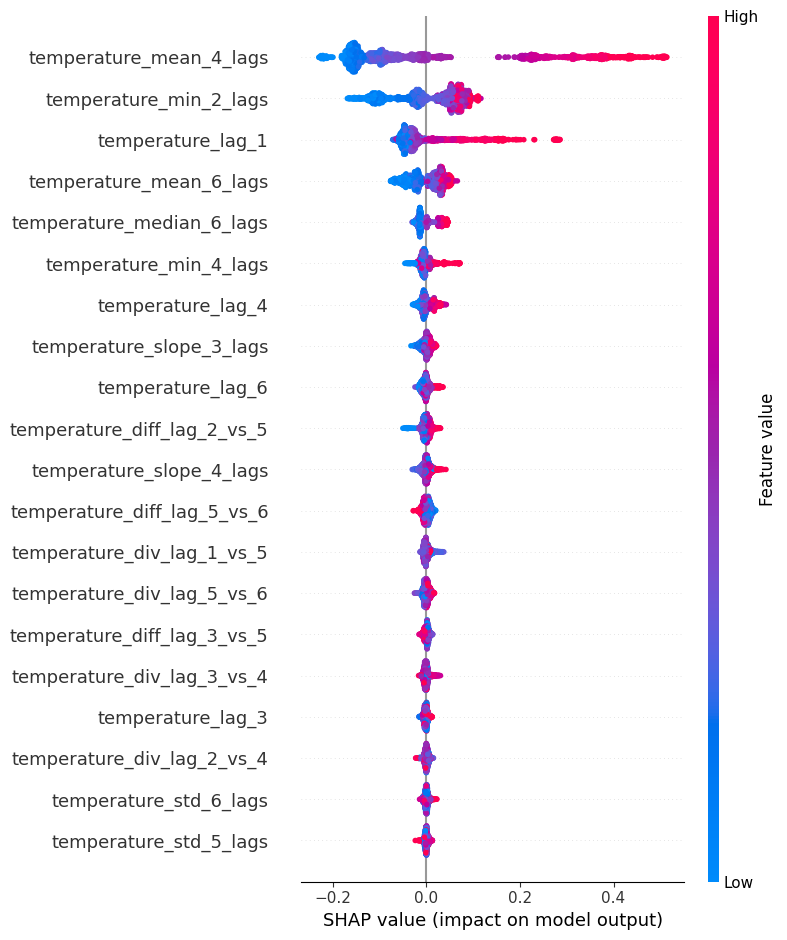

In [35]:
acv.get_result_analysis()

# Classifier

In [17]:
from dstoolkit.automl import AutoMLLGBMClassifier, AutoMLLGBMClassifierCV

In [21]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df[['SeriousDlqin2yrs']].rename({'SeriousDlqin2yrs': 'target'}, axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y['target'])
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42, stratify=y_temp['target'])

rfe = SequentialFeatureSelector(
    LGBMClassifier(verbose=0), 
    n_features_to_select=6, 
    direction='backward', 
    scoring='neg_brier_score', 
    cv=3
)
rfe.fit(X_train, y_train['target'])

best_features_class = X_train.loc[:, rfe.get_support()].columns.tolist()

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/v

In [22]:
a = AutoMLLGBMClassifier(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    scoring='brier'
)

In [23]:
a.train()

In [24]:
a.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   
3   Train  0.216080           0.736545   0.437360  0.521110  0.475576   
4   Valid  0.201005           0.727605   0.410144  0.507481  0.453650   
5    Test  0.201005           0.720826   0.394255  0.496259  0.439415   
6   Train  0.206030           0.723575   0.412275  0.498005  0.451103   
7   Valid  0.180905           0.733983   0.400699  0.524106  0.454169   
8    Test  0.221106           0.713708   0.410974  0.476309  0.441236   

        AUC        KS     Brier               Model  
0  0.902256  0.644746  0.044558          Base Model  
1  0.867222  0.579020  0.048628          Base Model  
2  0.859473  0.557068  0.049605          Base Model  
3  0.890542  0.614949  0.046003  Best Feature Model  
4  0.862060  0.572807  0.048932  Best Feature Model  
5  0.856866  0.551384  0.049731  Best Feature Model  
6  0.869611  0.581450  0.048350   Best Params Model  
7  0.864815  0.578412  0.048648   Best Params Model  
8  0.858072  0.555369  0.049327   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.902256  0.644746  0.044558  
1  0.867222  0.579020  0.048628  
2  0.859473  0.557068  0.049605

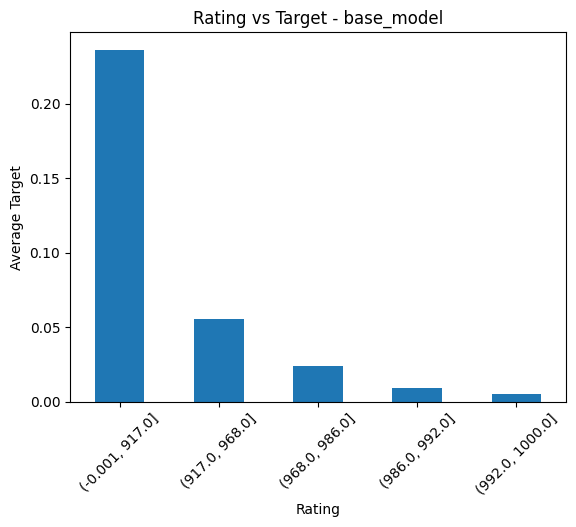

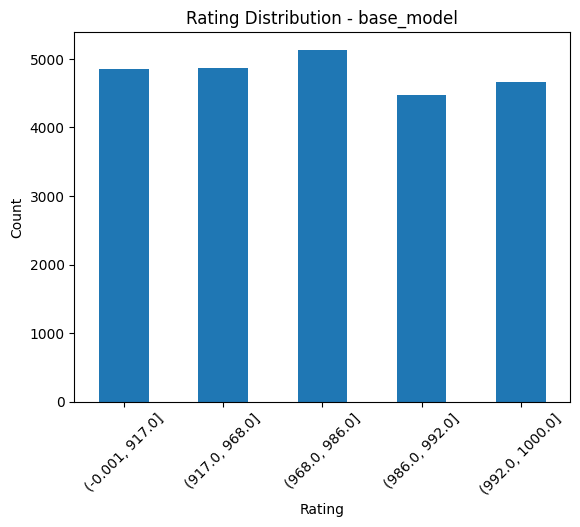

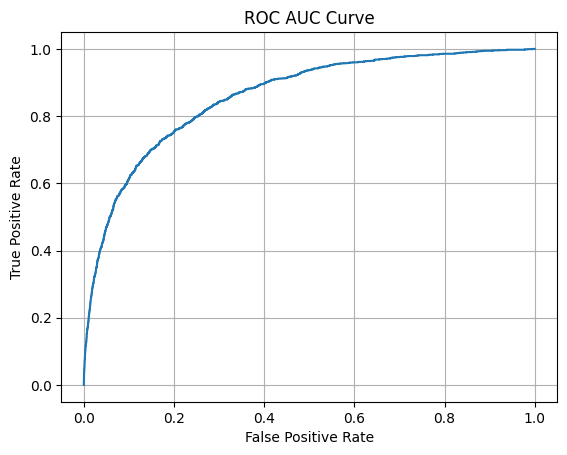

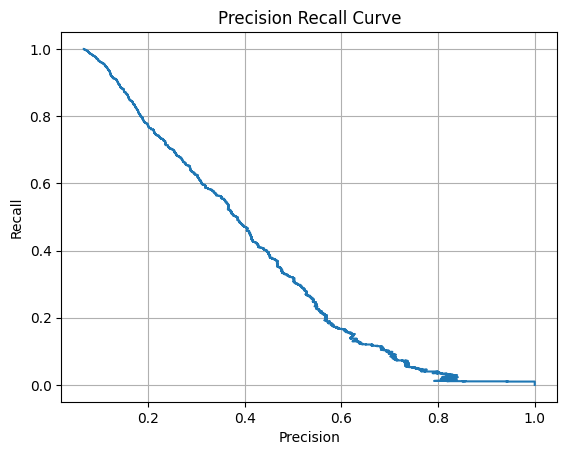

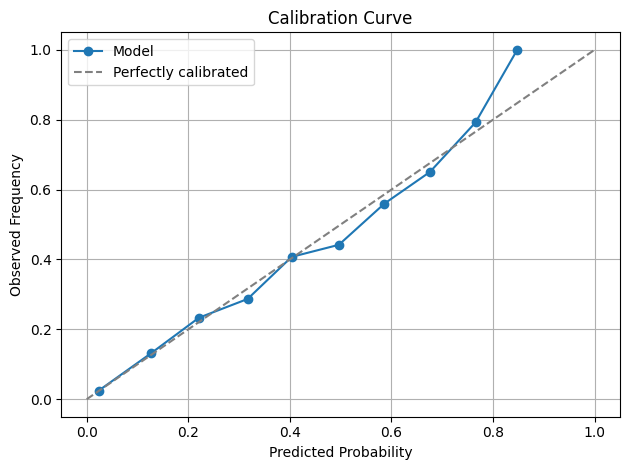

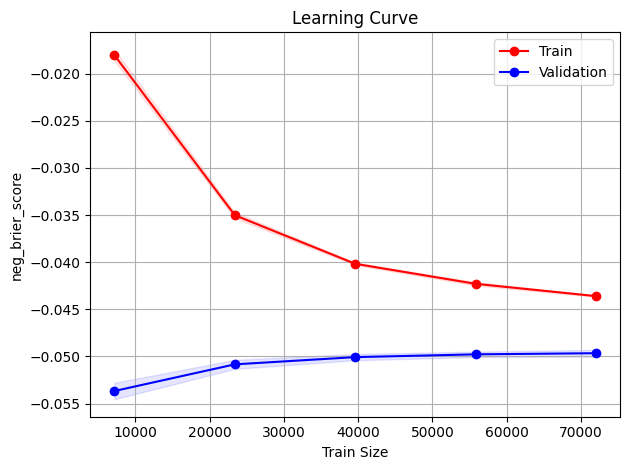

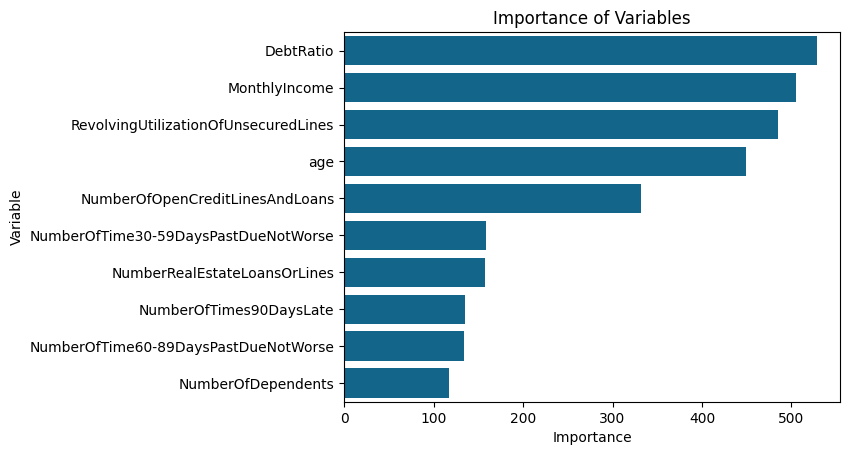

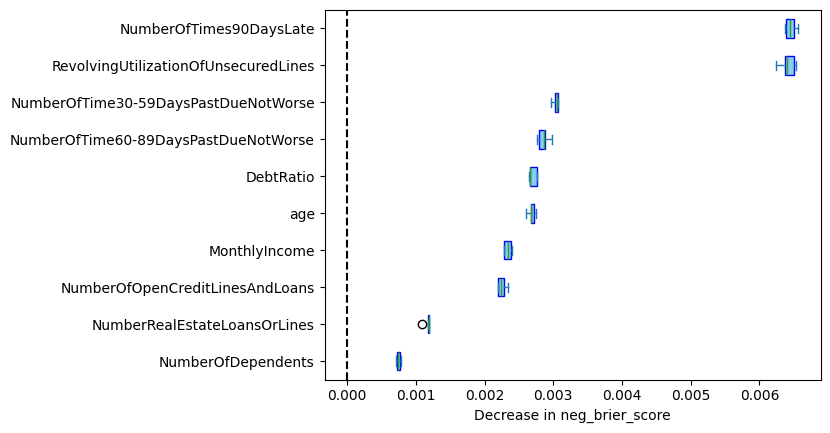

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


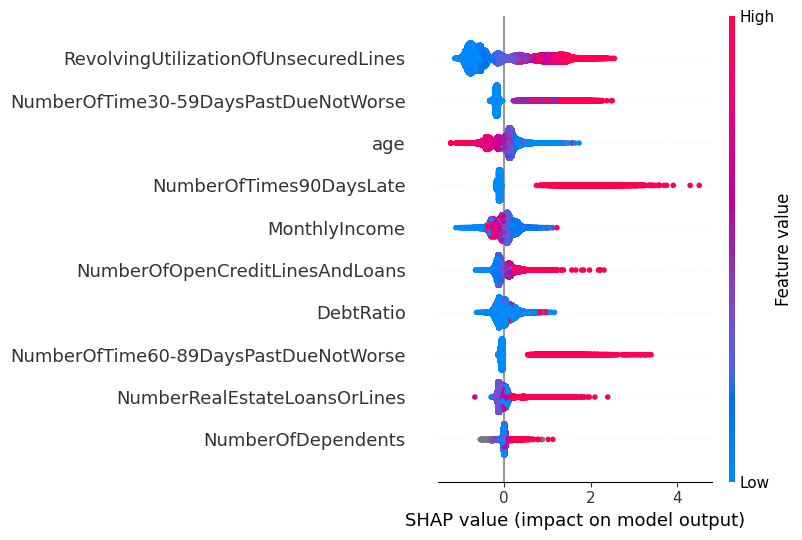

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.216080           0.736545   0.437360  0.521110  0.475576   
1   Valid  0.201005           0.727605   0.410144  0.507481  0.453650   
2    Test  0.201005           0.720826   0.394255  0.496259  0.439415   

        AUC        KS     Brier  
0  0.890542  0.614949  0.046003  
1  0.862060  0.572807  0.048932  
2  0.856866  0.551384  0.049731

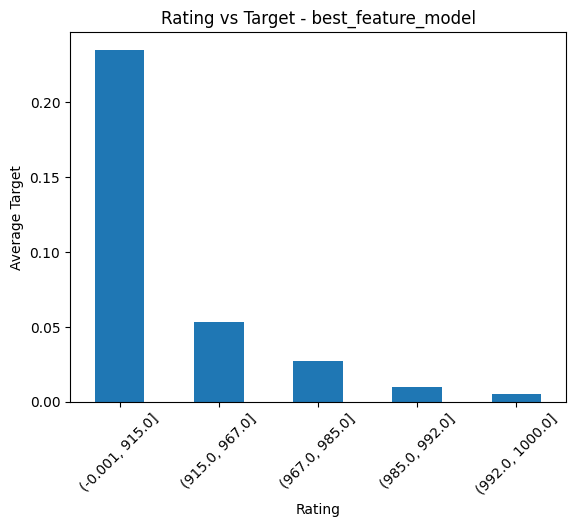

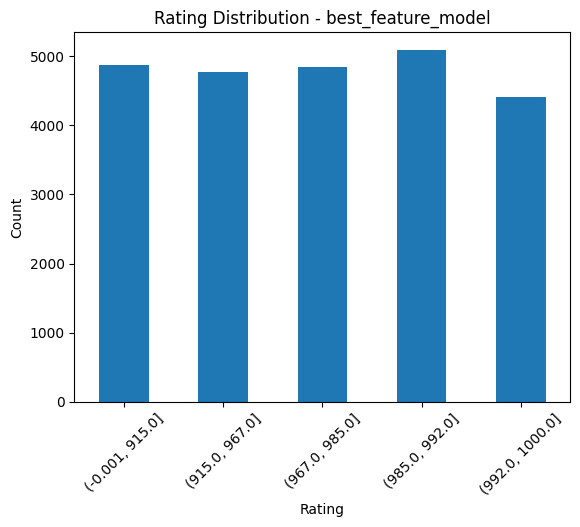

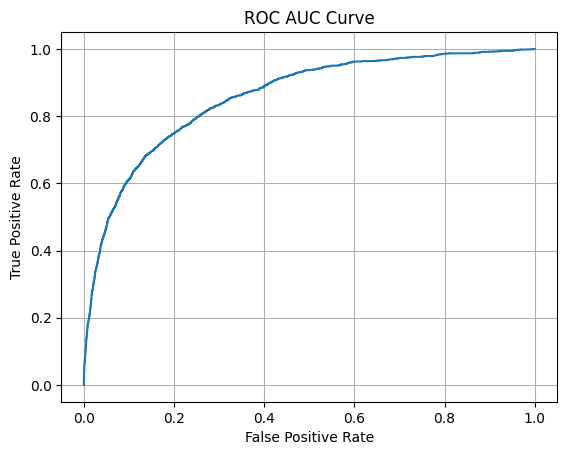

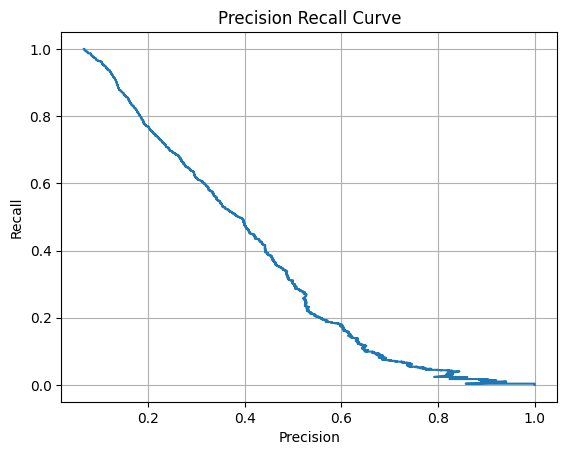

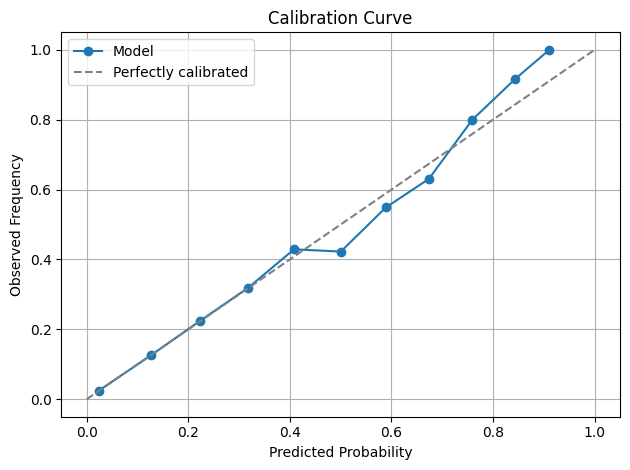

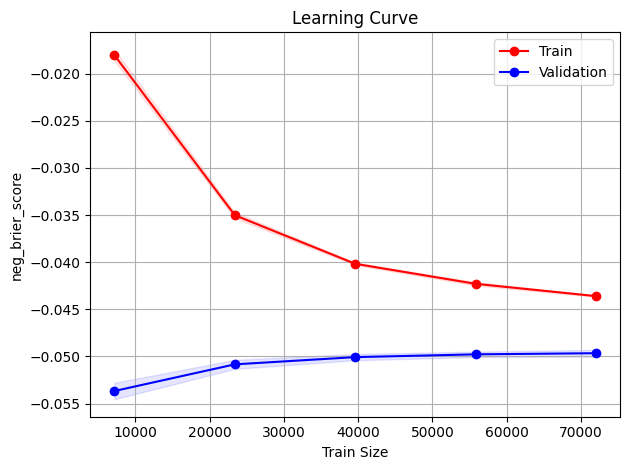

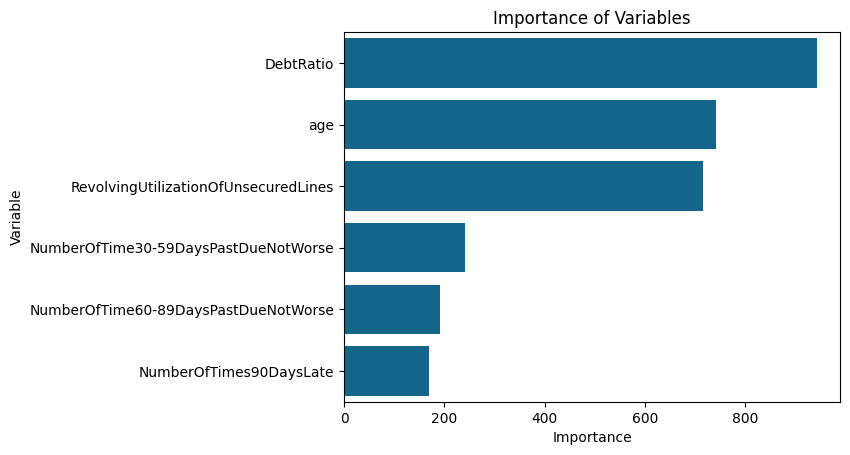

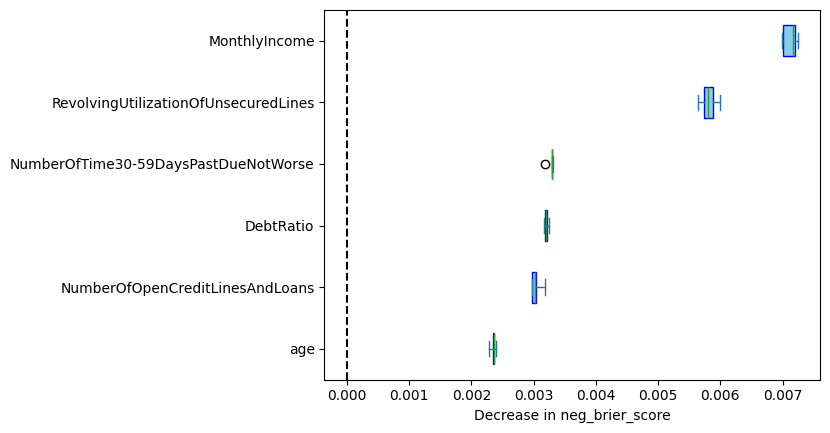

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


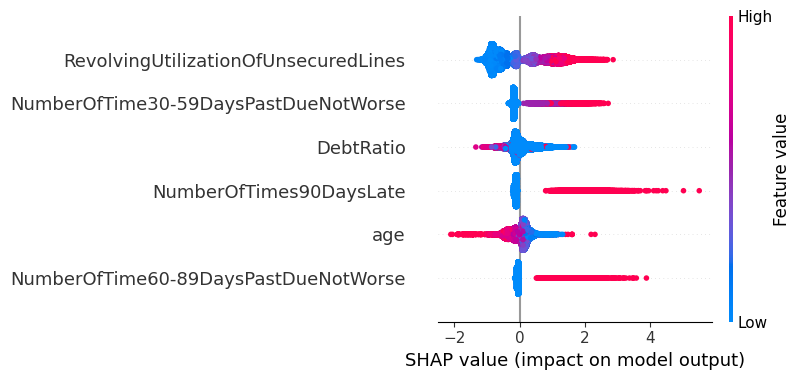

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.206030           0.723575   0.412275  0.498005  0.451103   
1   Valid  0.180905           0.733983   0.400699  0.524106  0.454169   
2    Test  0.221106           0.713708   0.410974  0.476309  0.441236   

        AUC        KS     Brier  
0  0.869611  0.581450  0.048350  
1  0.864815  0.578412  0.048648  
2  0.858072  0.555369  0.049327

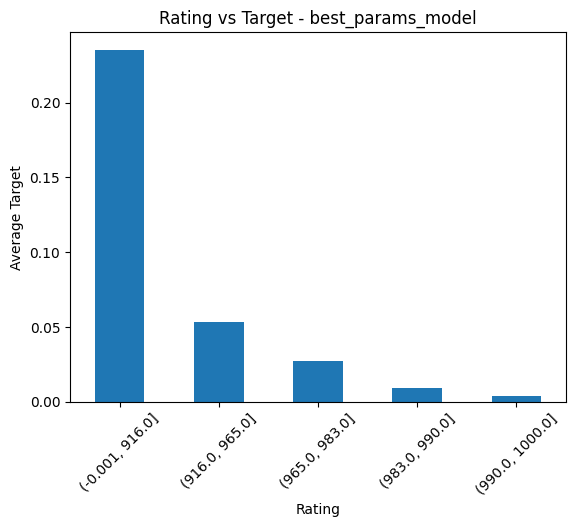

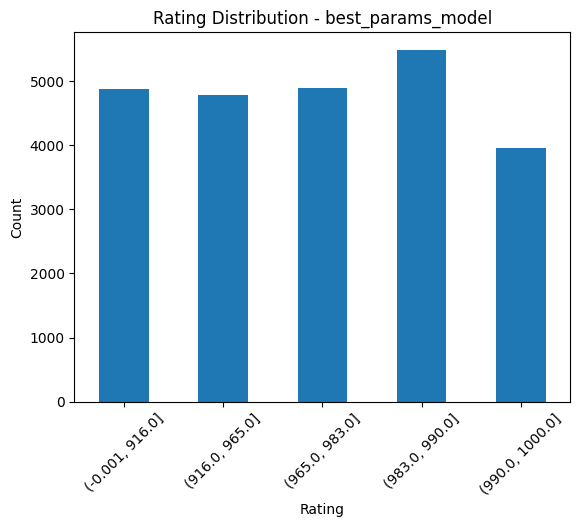

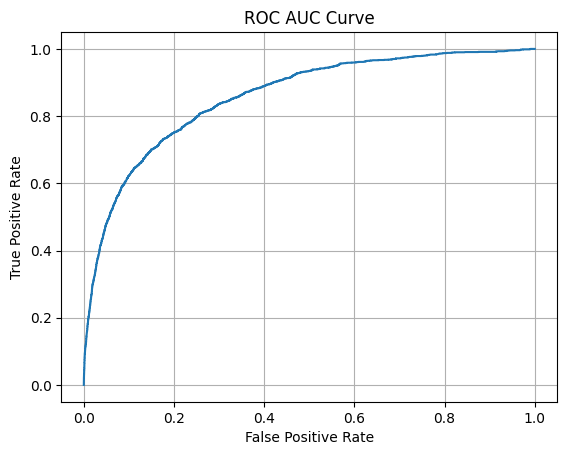

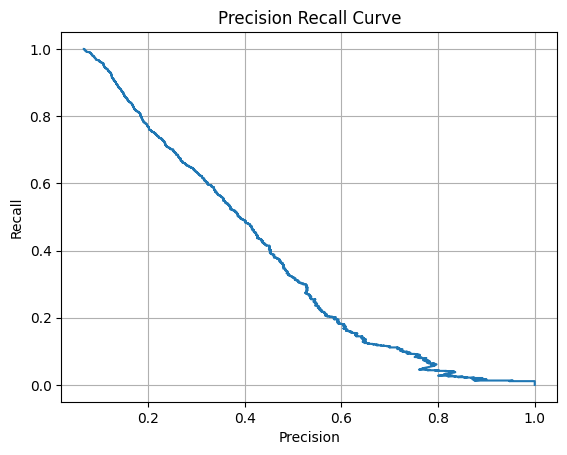

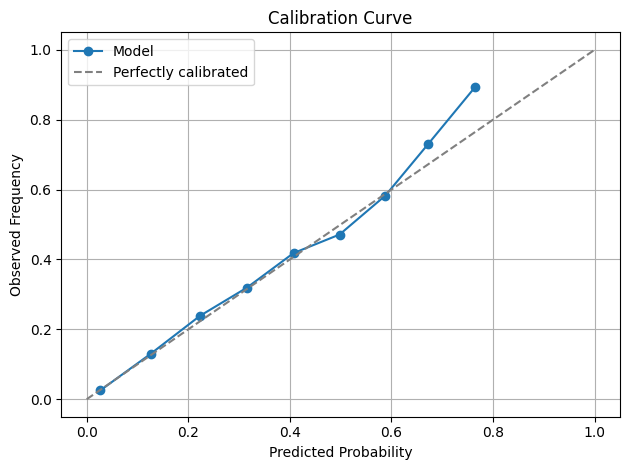

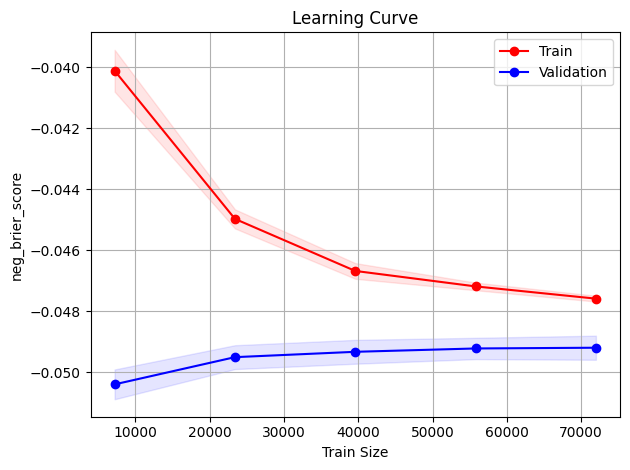

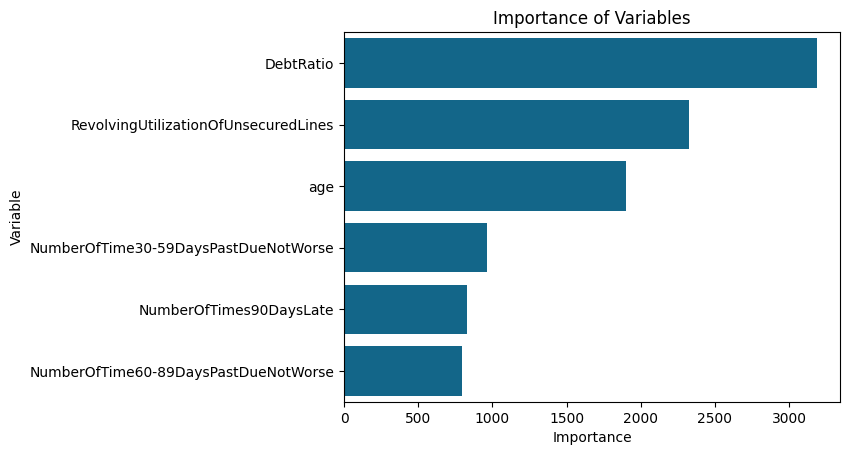

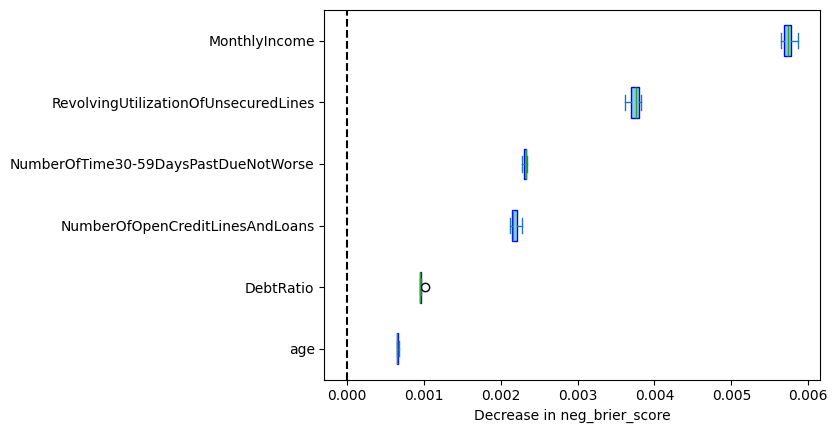

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


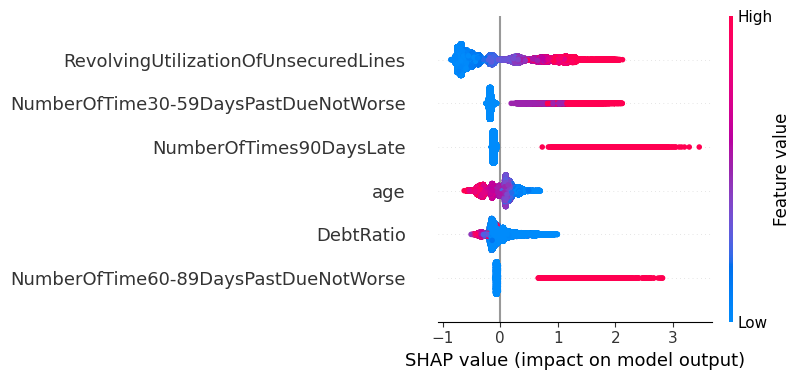

In [25]:
a.get_result_analysis()

In [26]:
acv = AutoMLLGBMClassifierCV(
    X_train, y_train, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='brier'
)

In [27]:
acv.train()

In [28]:
acv.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   
2  Train CV  0.500000           0.584893   0.586042  0.178859  0.273675   
3      Test  0.201005           0.720826   0.394255  0.496259  0.439415   
4  Train CV  0.500000           0.585137   0.595203  0.179025  0.275041   
5      Test  0.226131           0.711396   0.418799  0.469451  0.442681   

        AUC        KS     Brier               Model  
0  0.861749  0.571792  0.049660          Base Model  
1  0.859473  0.557068  0.049605          Base Model  
2  0.857731  0.565200  0.049887  Best Feature Model  
3  0.856866  0.551384  0.049731  Best Feature Model  
4  0.859971  0.568587  0.049441   Best Params Model  
5  0.857598  0.552642  0.049308   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.861749  0.571792  0.049660  
1  0.859473  0.557068  0.049605

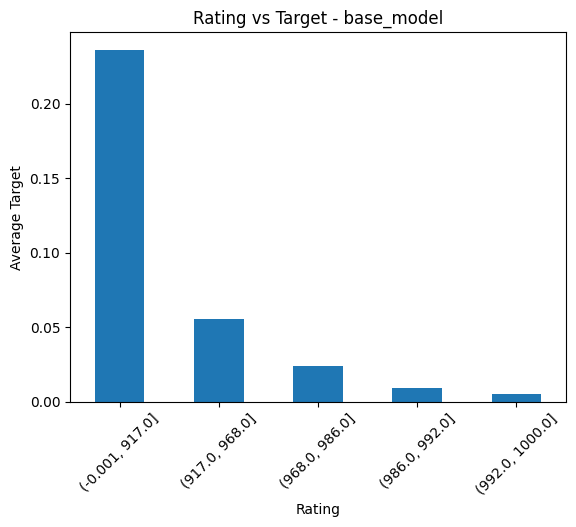

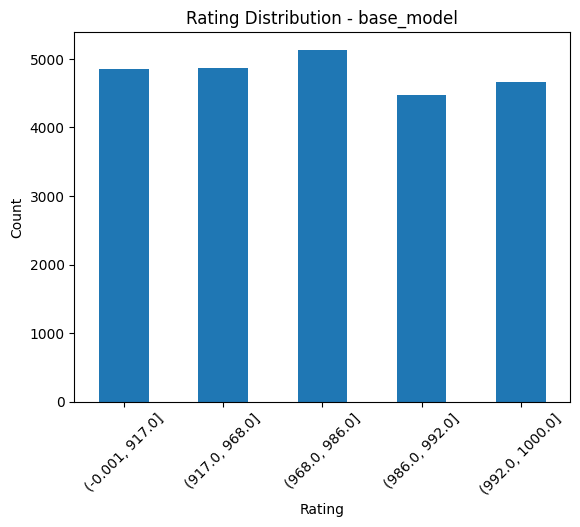

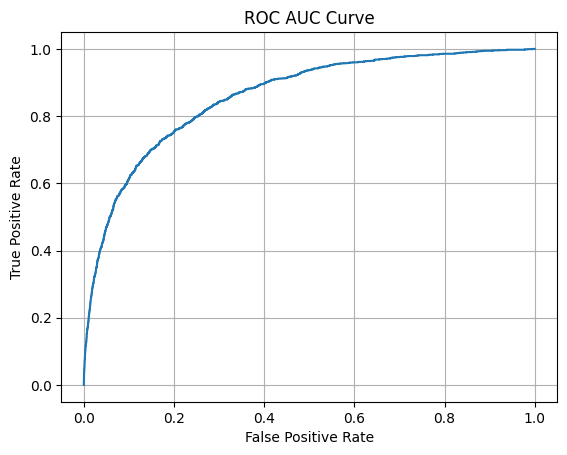

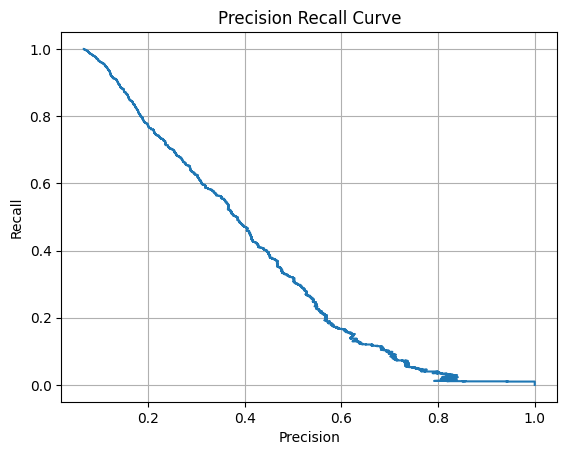

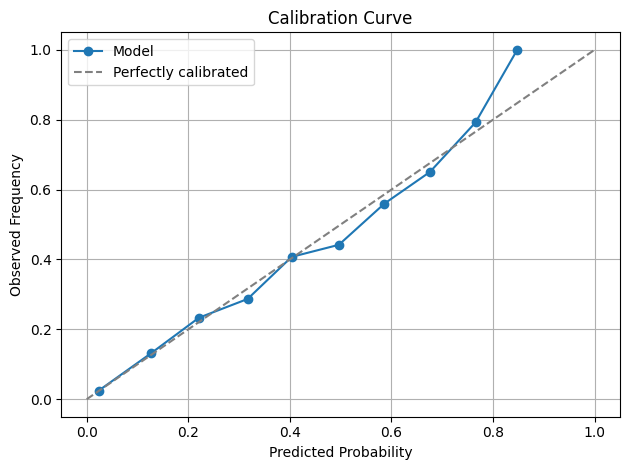

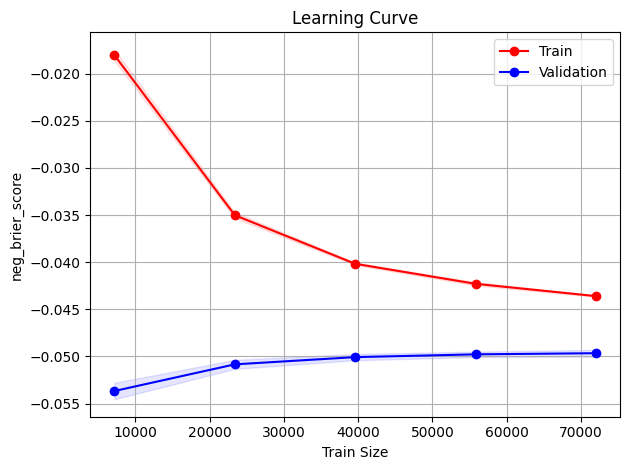

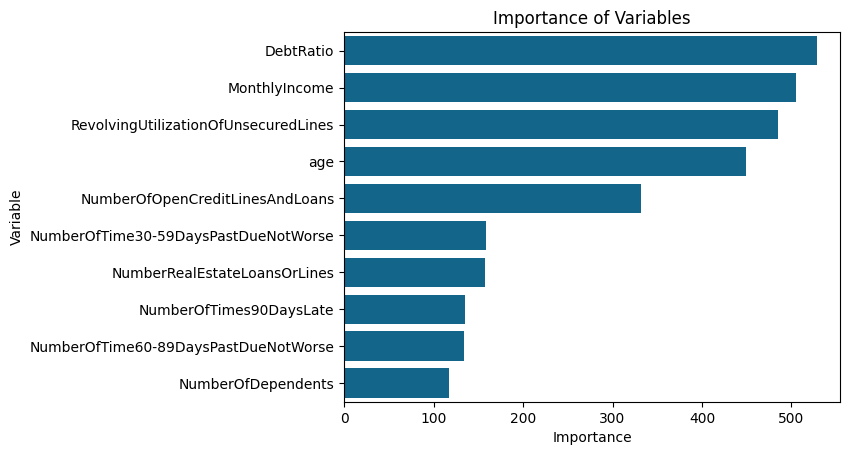

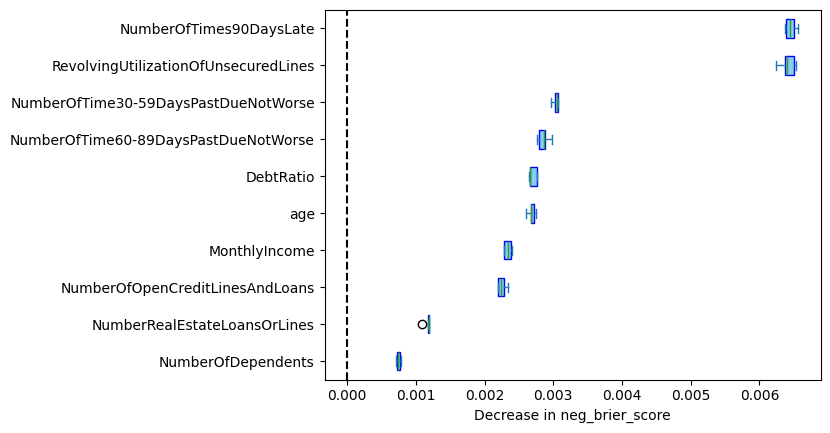

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


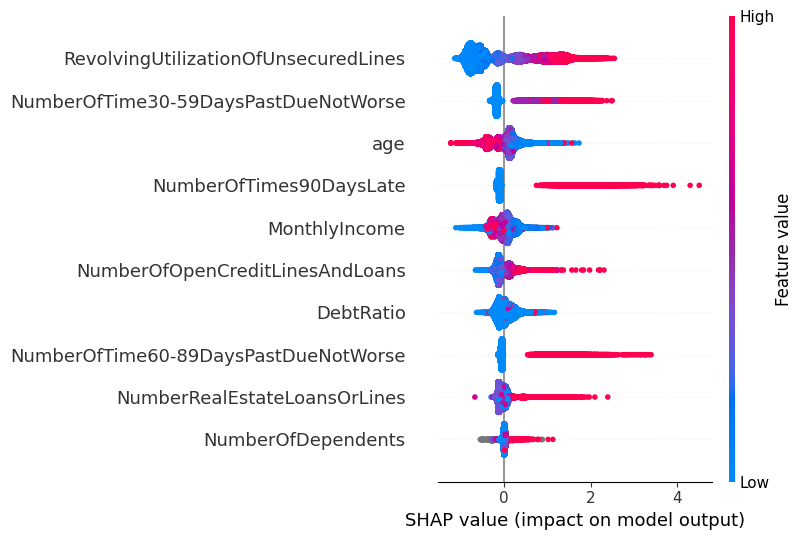

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.584893   0.586042  0.178859  0.273675   
1      Test  0.201005           0.720826   0.394255  0.496259  0.439415   

        AUC        KS     Brier  
0  0.857731  0.565200  0.049887  
1  0.856866  0.551384  0.049731

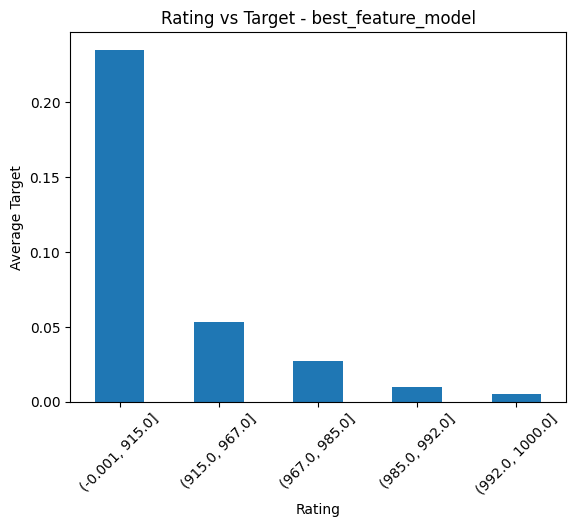

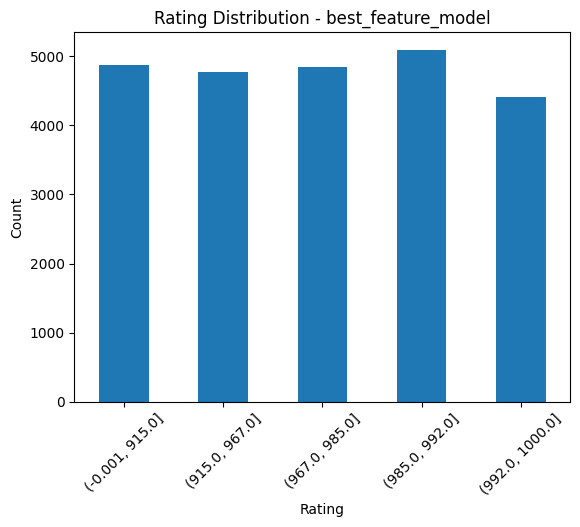

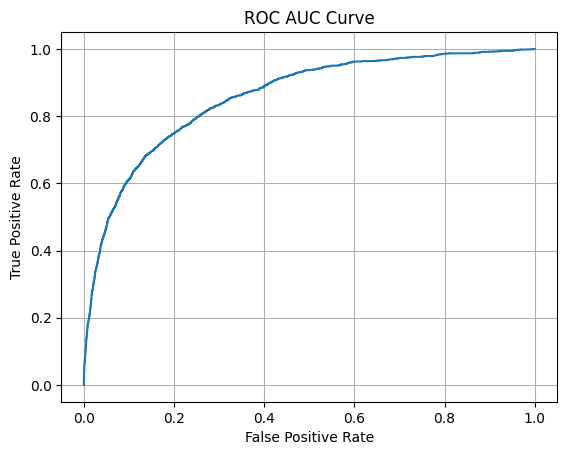

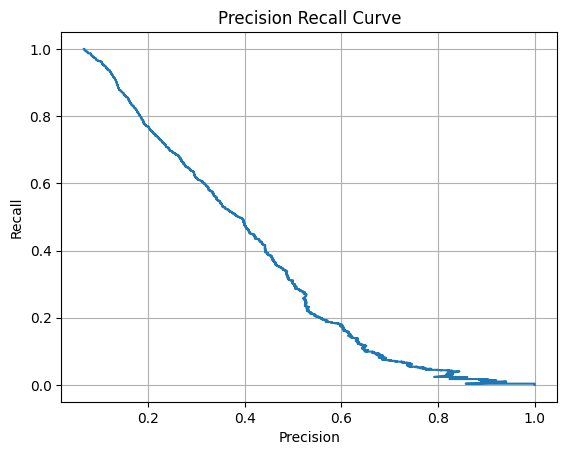

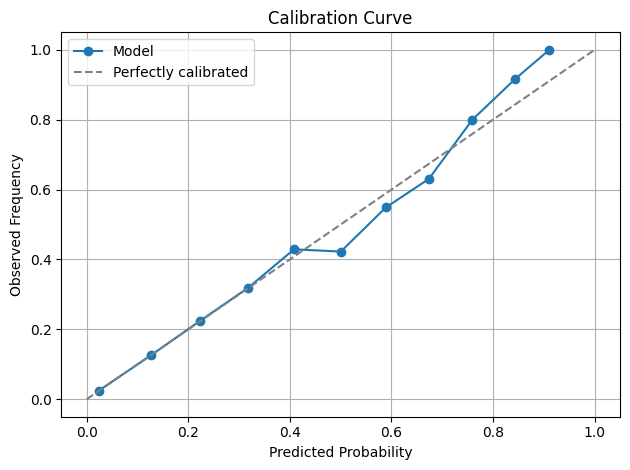

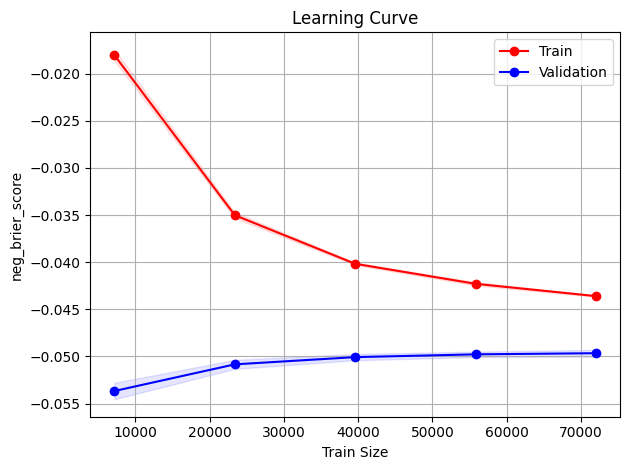

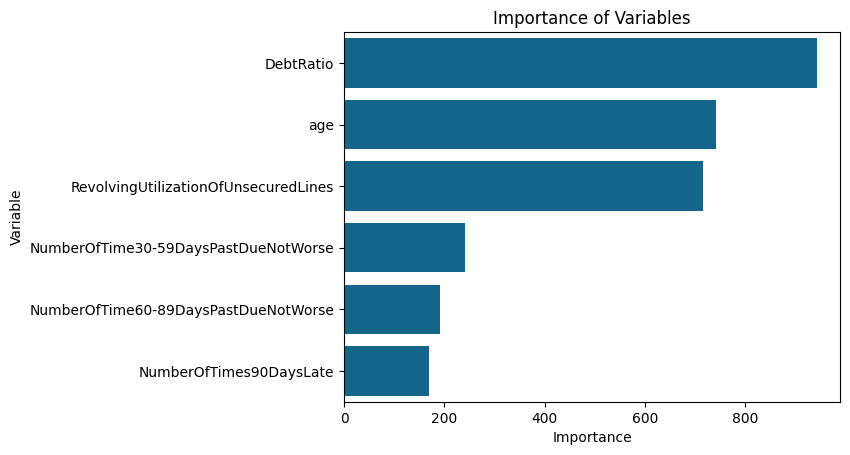

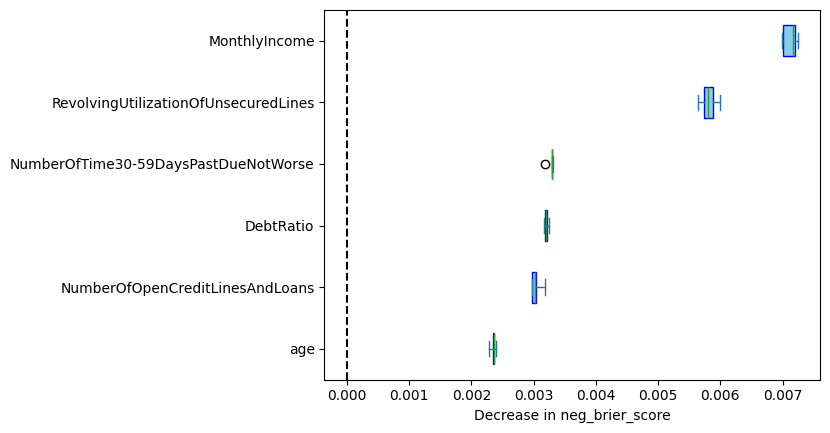

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


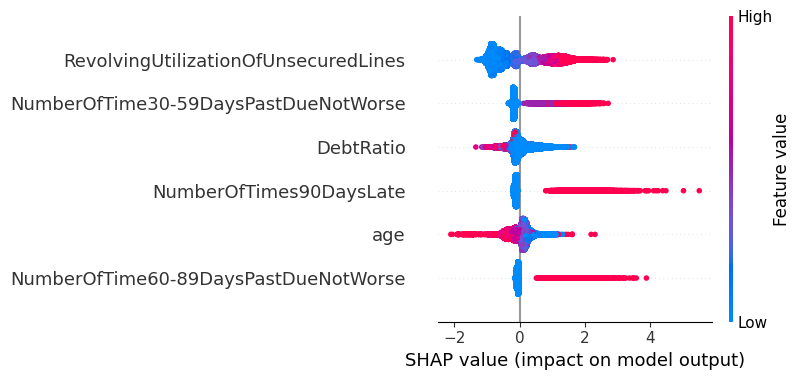

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.585137   0.595203  0.179025  0.275041   
1      Test  0.226131           0.711396   0.418799  0.469451  0.442681   

        AUC        KS     Brier  
0  0.859971  0.568587  0.049441  
1  0.857598  0.552642  0.049308

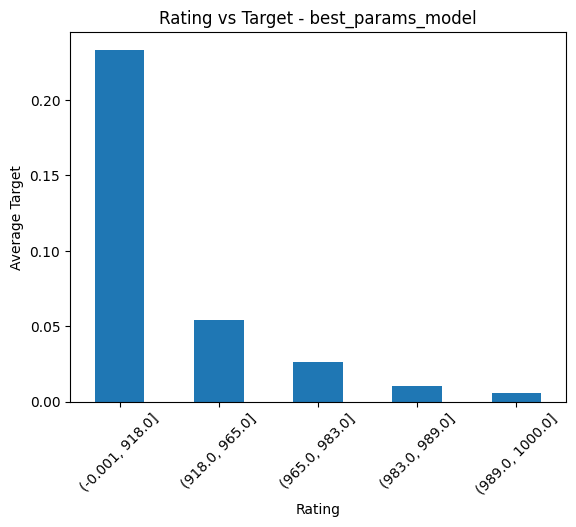

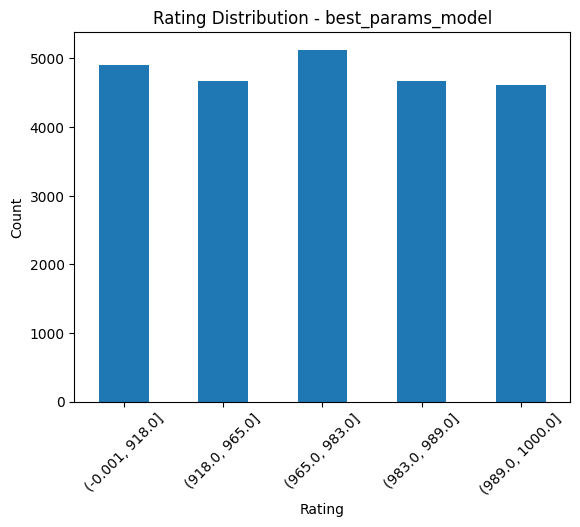

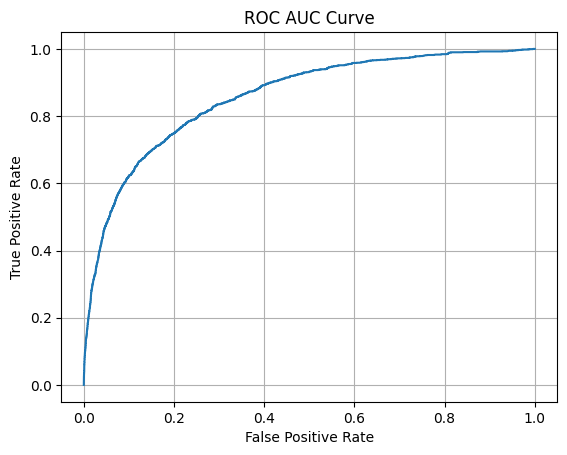

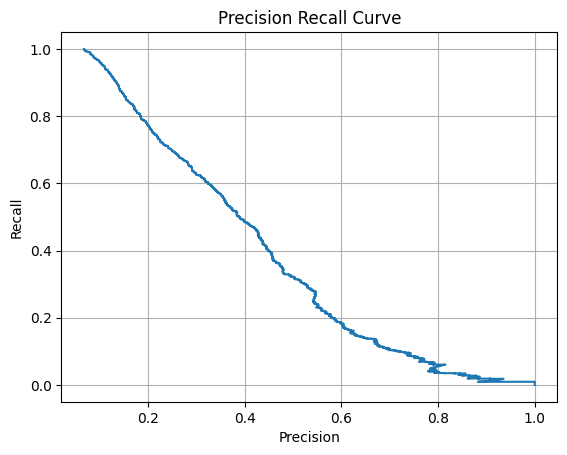

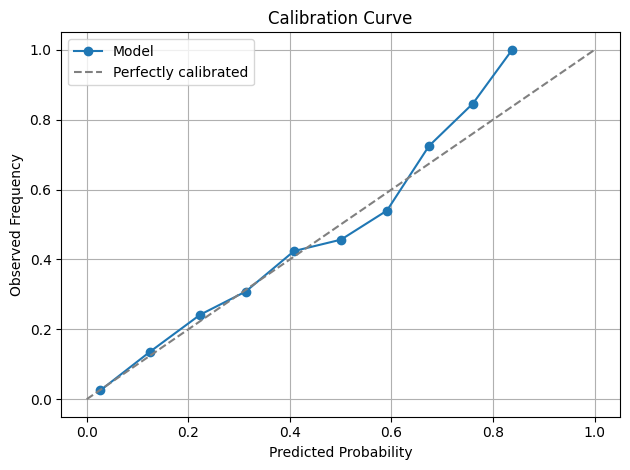

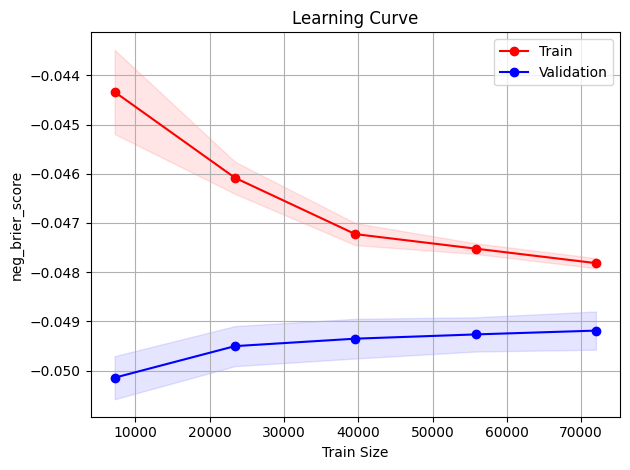

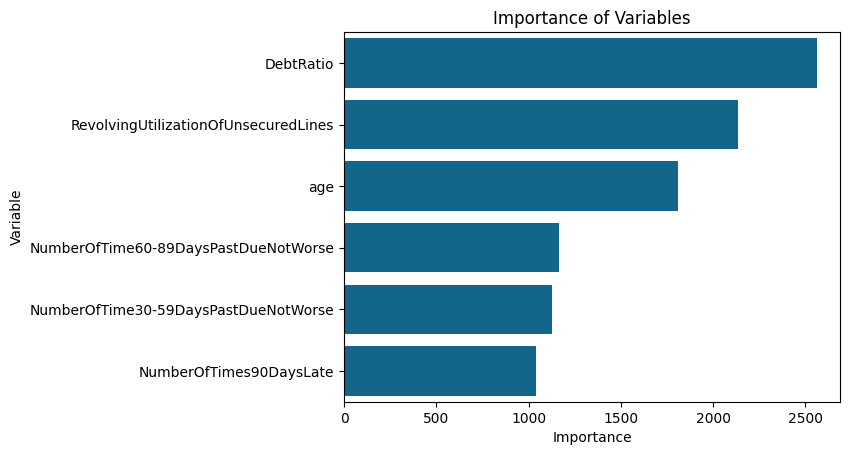

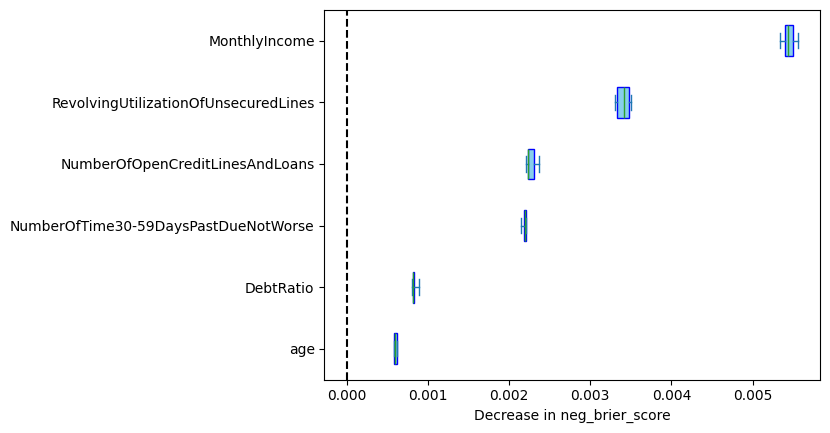

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


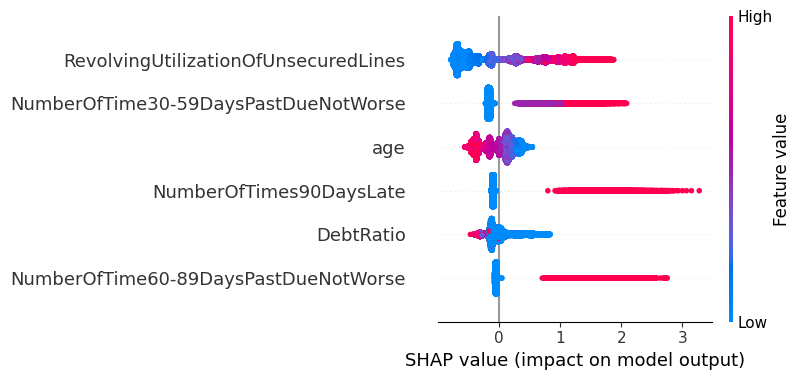

In [29]:
acv.get_result_analysis()